## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 30.7 MB/s eta 0:00:00


In [4]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


### 1.2 Imports

In [5]:
import os
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision.transforms as transforms

from livelossplot import PlotLosses
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)

#******** TODO: DELETE this part when modules are finalized *********#
# rerun everytime changes are made to the modules
import importlib
import utils.data_handler as dh
import utils.maskformer_dataset as mf_d
import utils.maskformer_evaluation as mf_ev
import utils.maskformer_inference as mf_inf
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics
import utils.mri_common as mri_common

importlib.reload(mf_utils)
importlib.reload(mri_common)
importlib.reload(metrics)
importlib.reload(mf_d)
importlib.reload(dh)
importlib.reload(mf_inf)
importlib.reload(mf_ev)
#******************************************************************#

# local imports
import utils.data_handler as dh
import utils.mri_common as mri_common
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics

from utils.maskformer_dataset import MaskformerMRIDataset, collate_fn
from utils.maskformer_evaluation import MaskFormerEvaluation
from utils.maskformer_inference import MaskFormerInference, get_mask_from_segm_result
from utils.data_handler import DataHandler, MriType

np.set_printoptions(precision=16)

# seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

data_handler = DataHandler()

### 1.3 Initializations (important!)

In [6]:
# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [249]:
# training variables:
RETRAIN = False
# train_dir_prefix = "maskformer/keith/mask_weight_30_small"
train_dir_prefix = "maskformer/huafeng"

# load existing model:
LOAD_MODEL = True
# model_dir_prefix = "maskformer/keith/mask_weight_30_small"
# model_file_name = "model_epoch40_all.pt"
model_dir_prefix = "maskformer/huafeng"
# model_file_name = "model_new_cross_front_small_2x_epoch16.pt"
# model_file_name = "model_new_depth_small_2x_epoch20_flat.pt"
# model_file_name = "model_new_cross_side_small_2x_epoch15.pt"
model_file_name = "model_new_cross_front_small_2x_epoch16.pt"

# variables for calculating metrics
RECALCULATE_TRAIN_METRICS = False
RECALCULATE_VAL_METRICS = False
RECALCULATE_TEST_METRICS = False
metrics_dir_prefix = "maskformer/keith/mask_weight_30_small"
train_metrics_file_name = "metrics_train_epoch40_all_ju29.joblib"
val_metrics_file_name = "metrics_val_epoch40_all_ju29.joblib"
test_metrics_file_name = "metrics_val_epoch40_all_ju29.joblib"

In [8]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that train directory
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {train_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

Chosen train_dir_prefix maskformer/huafeng has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using training_dir_prefix: maskformer/huafeng


In [9]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that metrics directory
dir_exists = data_handler.dir_exists(train_dir_prefix=metrics_dir_prefix)
if dir_exists:
  answer = input(f"Chosen metrics_dir_prefix {metrics_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new metrics directory...")
    metrics_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using metrics_dir_prefix: {metrics_dir_prefix}")

Chosen metrics_dir_prefix maskformer/keith/mask_weight_30_small has files stored. 
Are you sure you want to overwrite this folder? Reply YES: YES

Files will be saved using metrics_dir_prefix: maskformer/keith/mask_weight_30_small



## 2. Process 2D data

### 2.0 Initialize parameters

### 2.1 Load and select data

In [250]:
# MY_MRI_TYPE_TRAIN = MriType.TRAIN_2D_DEPTH
# MY_MRI_TYPE_VAL = MriType.VAL_2D_DEPTH
# MY_MRI_TYPE_TEST = MriType.TEST_2D_DEPTH

# MY_MRI_TYPE_TRAIN = MriType.TRAIN_2D_CROSS_SIDE
# MY_MRI_TYPE_VAL = MriType.VAL_2D_CROSS_SIDE
# MY_MRI_TYPE_TEST = MriType.TEST_2D_CROSS_SIDE

MY_MRI_TYPE_TRAIN = MriType.TRAIN_2D_CROSS_FRONT
MY_MRI_TYPE_VAL = MriType.VAL_2D_CROSS_FRONT
MY_MRI_TYPE_TEST = MriType.TEST_2D_CROSS_FRONT

In [251]:
# initialize filenames for saving entire dataset. suffix will give the slice direction
suffix = MY_MRI_TYPE_TRAIN.name.lower().split("2d_")[1]

train_list_full = f"data_train_all_{suffix}.txt"
val_list_full   = f"data_val_all_{suffix}.txt"
test_list_full   = f"data_test_all_{suffix}.txt"

# list all files from the directory
train_2d = data_handler.list_mri_in_dir(mri_type=MY_MRI_TYPE_TRAIN)
val_2d = data_handler.list_mri_in_dir(mri_type=MY_MRI_TYPE_VAL)
test_2d = data_handler.list_mri_in_dir(mri_type=MY_MRI_TYPE_TEST)

# save the list in another file only if they don't exist yet
train_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = train_list_full)
if not train_file_exists:
    data_handler.save_text(file_name = train_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in train_2d))

val_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = val_list_full)
if not val_file_exists:
    data_handler.save_text(file_name = val_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in val_2d))

test_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = test_list_full)
if not test_file_exists:
    data_handler.save_text(file_name = test_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in test_2d))


train_list_full, val_list_full, test_list_full

100%|██████████| 960M/960M [00:10<00:00, 91.2MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 84921/84921 [00:16<00:00, 5065.72it/s]
100%|██████████| 324M/324M [00:04<00:00, 74.8MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 28951/28951 [00:05<00:00, 5292.27it/s]
100%|██████████| 297M/297M [00:04<00:00, 64.6MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 27986/27986 [00:04<00:00, 5705.53it/s]


('data_train_all_cross_front.txt',
 'data_val_all_cross_front.txt',
 'data_test_all_cross_front.txt')

#### Using a small portion of data for efficient testing

In [252]:
# initialize filenames for saving a smaller sample
train_list = f"data_train_{suffix}.txt"
val_list   = f"data_val_{suffix}.txt"
test_list   = f"data_test_{suffix}.txt"

# select slice range
# n_total = 146 # n_depth
# n_total = 163 # n_cross_side
n_total = 193  # n_cross_front

# use if we want to use smaller sample starting from the middle slices
# file_no_min = n_total//2 - 20
# file_no_max = n_total//2 + 20

# if we want to use all slices
file_no_min = 0
file_no_max = n_total + 1

# select patent id range. 0 to 88 for entire range
subj_total = 88
subj_id_min = 0
subj_id_max = subj_total + 1

# define train and validation
# TODO: can we delete this code and just use train_2d and val_2d directly?
# subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
#                                                   train_dir_prefix=train_dir_prefix)
# subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
#                                                 train_dir_prefix=train_dir_prefix)

# obtain subset of training files
train_data_list = mf_utils.get_subset_files(train_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_data_list))

print(f"Number of unique training samples: {len(train_data_list)}")


# obtain subset of validation files
val_data_list = mf_utils.get_subset_files(val_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_data_list))
print(f"Number of unique validation samples: {len(val_data_list)}")

# obtain subset of test files
test_data_list = mf_utils.get_subset_files(test_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = test_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in test_data_list))
print(f"Number of unique validation samples: {len(test_data_list)}")

print("filename for smaller sample:", train_list, val_list, test_list)

Number of unique training samples: 16984
Number of unique validation samples: 5790
Number of unique validation samples: 5597
filename for smaller sample: data_train_cross_front.txt data_val_cross_front.txt data_test_cross_front.txt


### 2.2 Create Custom PyTorch Dataset


In [253]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [254]:
# load sample list from text file saved from 2.1
# TODO: again, confirm if loading from text file is still needed
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=train_dir_prefix)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=train_dir_prefix)
test_data_list = data_handler.load_text_as_list(file_name = test_list, train_dir_prefix=train_dir_prefix)

# Get the first file name from the train_data_list
orig_dim = data_handler.load_mri(subj_id=train_data_list[0].split('_')[0], mri_type=MY_MRI_TYPE_TRAIN,
                                 file_no=int(train_data_list[0].split('_')[1].split('.')[0])).shape
# training resolution
#height, width = 163, 193    #original dimensions
#height, width = 489, 579    #3x
# height, width = 512, 512
# height, width = 652, 772    #4x
#height, width = 815, 965    #5x
#height, width = 897, 1062   #5.5x
#height, width = 978, 1158   #6x

# height, width = 512, 512    # depth 512x512
# height, width = 326, 386    # depth
# height, width = 386, 292    # cross_side
height, width = 326, 292    # cross_front

# define data transforms
train_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# create datasets
train_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_TRAIN, data_list=train_data_list, processor=processor, transform=train_transform, augment=True)
val_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_VAL, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)
test_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_TEST, data_list=test_data_list, processor=processor, transform=train_transform, augment=False)

# setup data loader
# batch_size = 2 # for the 512x512
batch_size = 16 # for the 2x resolition cases

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### 2.3 QC dataset

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([1, 326, 386])
class_labels torch.Size([1])
12848
tensor([0])


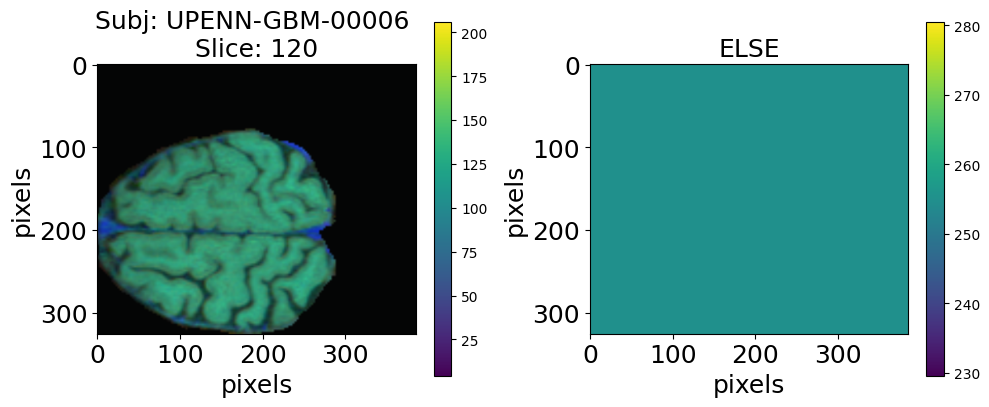

In [172]:
# peek at the train dataset
train_input = train_dataset[120]
for k,v in train_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(train_input["class_labels"])

train_img_title = f"Subj: {train_input['subj_no']} \nSlice: {train_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=train_input["class_labels"].tolist(),
             pixel_values = train_input['pixel_values'].numpy(),
             mask_labels = train_input['mask_labels'],
             title = train_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([2, 326, 386])
class_labels torch.Size([2])
4380
tensor([0, 2])


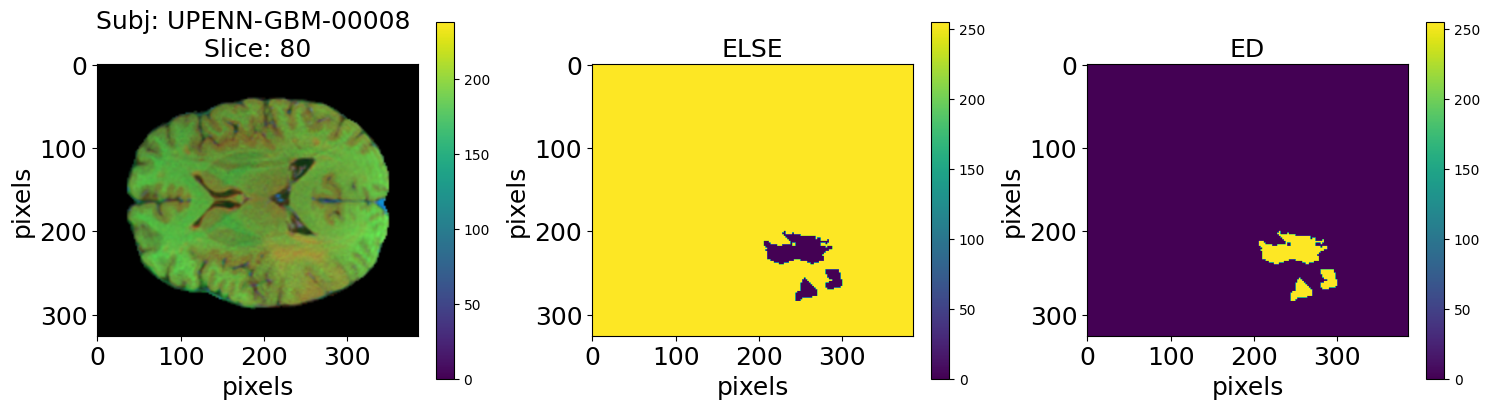

In [173]:
# peek at the val dataset
val_input = val_dataset[80]
for k,v in val_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(val_input["class_labels"])

# plot val dataset
val_img_title = f"Subj: {val_input['subj_no']} \nSlice: {val_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=val_input["class_labels"].tolist(),
             pixel_values = val_input['pixel_values'].numpy(),
             mask_labels = val_input['mask_labels'],
             title= val_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([4, 326, 386])
class_labels torch.Size([4])
4234
tensor([0, 1, 2, 3])


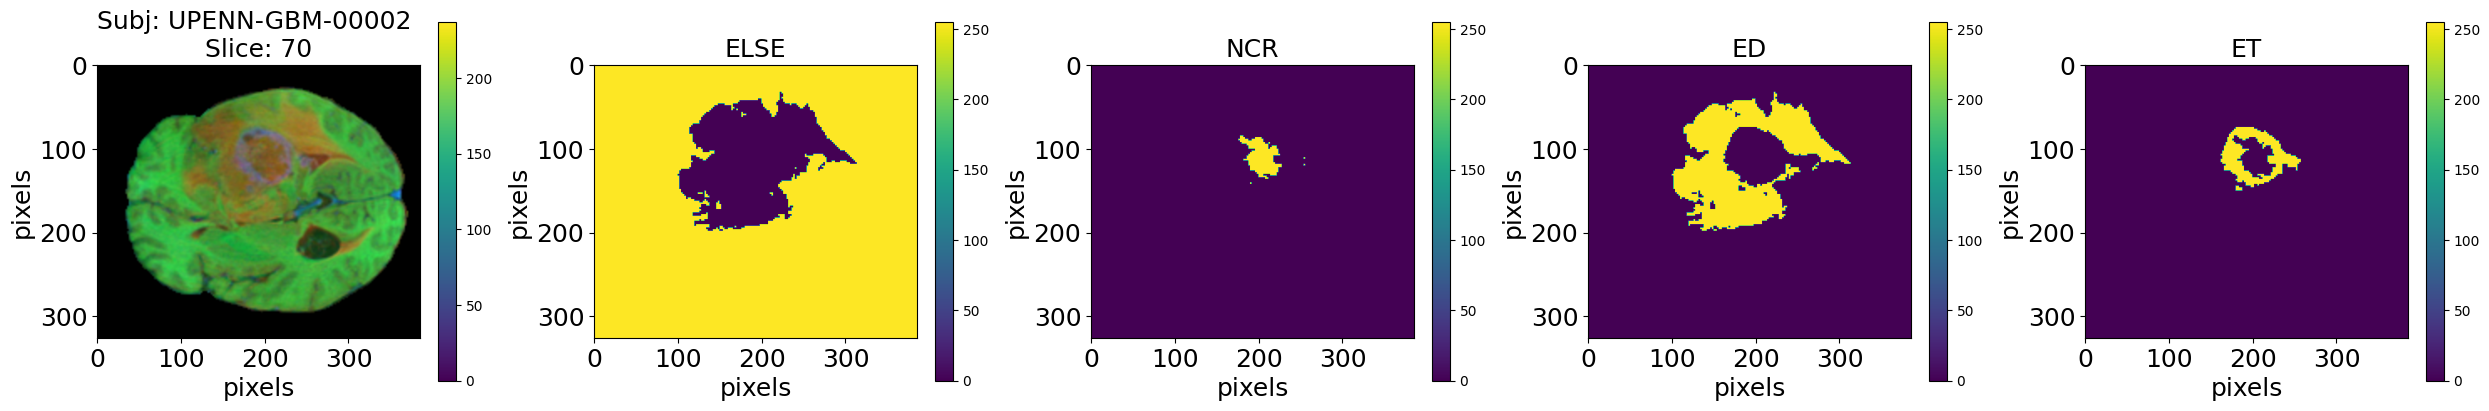

In [174]:
# peek at the Test dataset
test_input = test_dataset[70]
for k,v in test_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(test_dataset))
print(test_input["class_labels"])

# plot Test dataset
test_img_title = f"Subj: {test_input['subj_no']} \nSlice: {test_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=test_input["class_labels"].tolist(),
             pixel_values = test_input['pixel_values'].numpy(),
             mask_labels = test_input['mask_labels'],
             title= test_img_title)

## 3. Fine-tuning Model

### 3.1 Define the model

In [255]:
# Make label dictionary
id2label = mri_common.SEGMENTS.copy()
print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-small-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# based model only used for the 512x512 case
# model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-base-ade",
#                                                           id2label=id2label,
#                                                           label2id=label2id,
#                                                           ignore_mismatched_sizes=True)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-small-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [256]:
# load saved model if needed
if LOAD_MODEL == True:
    model = data_handler.load_torch_model(file_name=model_file_name, train_dir_prefix=model_dir_prefix, device=device)

In [257]:
# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1
# model.config.cross_entropy_weight  = 10000.0
# model.config.use_auxiliary_loss = False
# model.config.ce_weight = 10000.0

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_commit_hash": "f4097ad31123b84e35d4f9e977f746fa703c12ab",
  "_name_or_path": "zuppif/maskformer-swin-small-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 96,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
 

In [258]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, width, height), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [16, 3, 292, 326]    [16, 8, 100, 100]    --                   True
├─MaskFormerModel (model)                                                                       [16, 3, 292, 326]    [16, 8, 100, 100]    --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [16, 3, 292, 326]    --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [16, 3, 292, 326]    [16, 96, 73, 82]     48,840,138           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [16, 96, 73, 82]     --                   4,304,640            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [ ]:
# # obtain a batch of data
# batch = next(iter(train_dataloader))

# model.to(device)

# outputs = model(
#         pixel_values=batch["pixel_values"].to(device),
#         mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
#         class_labels=[labels.to(device) for labels in batch["class_labels"]],
#       )
# loss_init = outputs.loss.item()

# # print basic info
# for k,v in batch.items():
#   if isinstance(v, torch.Tensor):
#     print(k,v.shape)
#   else:
#     print(k,len(v))

# # print some info
# print([label.shape for label in batch["class_labels"]])
# print([label.shape for label in batch["mask_labels"]])

# # print loss
# print('Initial Loss is:', loss_init)


### 3.3 Train the model

In [ ]:
# TODO: move this to a train function and parameterize hyperparameters

if RETRAIN:

    liveloss = PlotLosses()

    batch_max = 100000
    loss_train = []
    loss_val = []
    min_loss = 1e9
    # mutiplier is used to scale loss values to be more readable
    loss_multiplier = 10.0

    # define number of epochs in training
    n_epoch = 10

    # saving model half way
    SAVE_INT = n_epoch // n_epoch

    # define learning rate
    # lr = 2e-5
    lr = 1e-5
    # lr = 0.5e-5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)*loss_multiplier) )
    logs = {}
    # logs['loss'] = loss_init
    # logs['val_loss'] = loss_init

    # liveloss.update(logs)
    # liveloss.send()

    for epoch in range(1,n_epoch+1):
        print("Starting Epoch:", epoch)

        ## training loop
        running_loss = 0.0
        num_samples = 0
        model.train()
        for ibatch, batch in enumerate(tqdm(train_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Reset the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # Backward propagation
                loss = outputs.loss * loss_multiplier
                loss.backward()

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_train_cur = running_loss/num_samples

                # Optimization
                optimizer.step()
            else:
                # skip where ibatch >= batch_max
                break

        # record loss at the end of each epoch
        logs['loss'] = loss_train_cur
        print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
        loss_train.append(loss_train_cur)

        ## validation loop
        running_loss = 0.0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for ibatch, batch in enumerate(tqdm(val_dataloader)):
                # run partial data based on input limit
                if ibatch < batch_max:
                    # Forward pass
                    outputs = model(
                            pixel_values=batch["pixel_values"].to(device),
                            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                            class_labels=[labels.to(device) for labels in batch["class_labels"]],
                    )

                    # loss
                    loss = outputs.loss  * loss_multiplier

                    batch_size = batch["pixel_values"].size(0)
                    running_loss += loss.item()
                    num_samples += batch_size
                    loss_val_cur = running_loss/num_samples
                else:
                    # skip where ibatch >= batch_max
                    break

        # record loss at the end of each epoch
        logs['val_loss'] = loss_val_cur
        # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
        loss_val.append(loss_val_cur)

        # if found better model, update min_loss and save model (currently using training loss)

        if min_loss > loss_val_cur:
            print("Saved model in epoch",epoch)
            # save the best model
            # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
            min_loss = loss_val_cur

        # save model regularly
        if epoch%SAVE_INT == 0:
            print("Saved model in epoch",epoch)

            # save the best model
            data_handler.save_torch_model(file_name='model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

        # Update the plot with new logging information.
        liveloss.update(logs)
        liveloss.send()

    # save loss at the end
    data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
    data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

## 4. Evaluation

### 4.1 Make prediction on one sample

#### 4.1.1 Model prediction and visualization on one sample

In [259]:
# define a transform without resizing
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# create a test data loader without shuffling
# QC_TYPE = 'val'
QC_TYPE = 'test'

# fixed batch size for now
batch_size = 10
if QC_TYPE == 'train':

    # uses the same transformation during training
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_TRAIN, data_list=train_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
elif QC_TYPE == 'val':
    # uses the same transformation during training
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_VAL, data_list=val_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    # uses the same transformation during training
    qc_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_TEST, data_list=test_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [260]:
# # TO QC a specific subj: UPENN-GBM-00131 and file number
# target_subj = "UPENN-GBM-00013"

# # find the index/indices in val_data_list corresponding to the 2d slices for the specified patient
# subj_indices = [index for index, file_name in enumerate(val_data_list) if target_subj in file_name]

# # specify which slice/file_no
# test_file_no = 125

# # get relative index of test_file_no
# target_file_no = subj_indices[0] + test_file_no
# target_batch = int(target_file_no//batch_size)
# test_idx = target_file_no%batch_size
# print("target batch", target_batch)
# print("test idx", test_idx)

In [261]:
# TO QC a specific subj: UPENN-GBM-00131 and file number
target_subj = "UPENN-GBM-00002"

# find the index/indices in test_data_list corresponding to the 2d slices for the specified patient
subj_indices = [index for index, file_name in enumerate(test_data_list) if target_subj in file_name]

# specify which slice/file_no
test_file_no = 50

# get relative index of test_file_no
target_file_no = subj_indices[0] + test_file_no
target_batch = int(target_file_no//batch_size)
test_idx = target_file_no%batch_size
print("target batch", target_batch)
print("test idx", test_idx)

target batch 5
test idx 0


In [262]:
# obtain targeted batch of data. note that we used batch_size = 1
# therefore, batch index is the same as the file index from our datalist
# also, the loader will be slow if we have a large index.

# we can override target_batch and test_idx if testing randomly
# target_batch = 10
# test_idx = 0

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
  else:
    print(k, len(v))

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_labels = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]
print(test_subj)

pixel_values torch.Size([10, 3, 326, 292])
pixel_mask torch.Size([10, 326, 292])
class_labels 10
mask_labels 10
subj_no 10
file_no 10
UPENN-GBM-00002_50


In [263]:
# # prepare transform to use for inferencing. should be the same as train_transform
# predict_transform = A.Compose([
#     A.Resize(width=width, height=height),
#     A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
# ])

# # MaskFormerInference will take care of prediction but batch size for now is fixed to 1
# test_mf_inference=MaskFormerInference(data_handler=data_handler,
#                                      data_identifier=MY_MRI_TYPE_VAL,
#                                      model=model,
#                                      processor=processor,
#                                      upscaled_transform=predict_transform,
#                                      scale_to_orig_size=False)

# # outputs = model output
# # result = this is the method that runs MaskFormer post_process_semantic_segmentation
# outputs, batch_results = test_mf_inference.predict_segm(test_batch, batch_size=batch_size)

# # use test_idx to get results from batch
# results = batch_results[test_idx]

# for segment_info in results['segments_info']:
#     print(segment_info)
# print("segmentation result shape", results['segmentation'].shape)
# print("segmentation unique values", np.unique( results['segmentation']))

In [264]:
# prepare transform to use for inferencing. should be the same as train_transform
predict_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

# MaskFormerInference will take care of prediction but batch size for now is fixed to 1
test_mf_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_TEST,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)

# outputs = model output
# result = this is the method that runs MaskFormer post_process_semantic_segmentation
outputs, batch_results = test_mf_inference.predict_segm(test_batch, batch_size=batch_size)

# use test_idx to get results from batch
results = batch_results[test_idx]

for segment_info in results['segments_info']:
    print(segment_info)
print("segmentation result shape", results['segmentation'].shape)
print("segmentation unique values", np.unique( results['segmentation']))

{'id': 0, 'label_id': 2, 'was_fused': False, 'score': 0.944696}
{'id': 1, 'label_id': 0, 'was_fused': False, 'score': 0.994815}
segmentation result shape torch.Size([326, 292])
segmentation unique values [-1.  0.  1.]


In [265]:
# Obtain labels in true, predict, intersection and union
labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )

# remove duplicates
labels_pred = list(set(labels_pred))
labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:", labels_all)
print("Common labels:",labels_common)

True labels: ['ELSE', 'ED']
Predicted labels: ['ED', 'ELSE']
All labels: ['ELSE', 'ED']
Common labels: ['ED', 'ELSE']


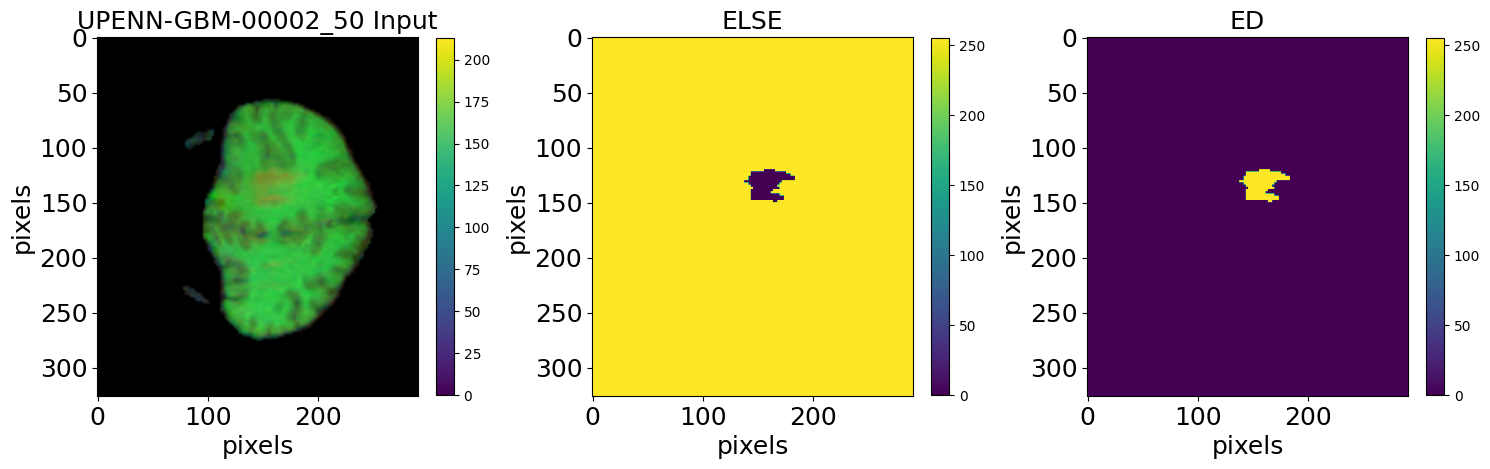

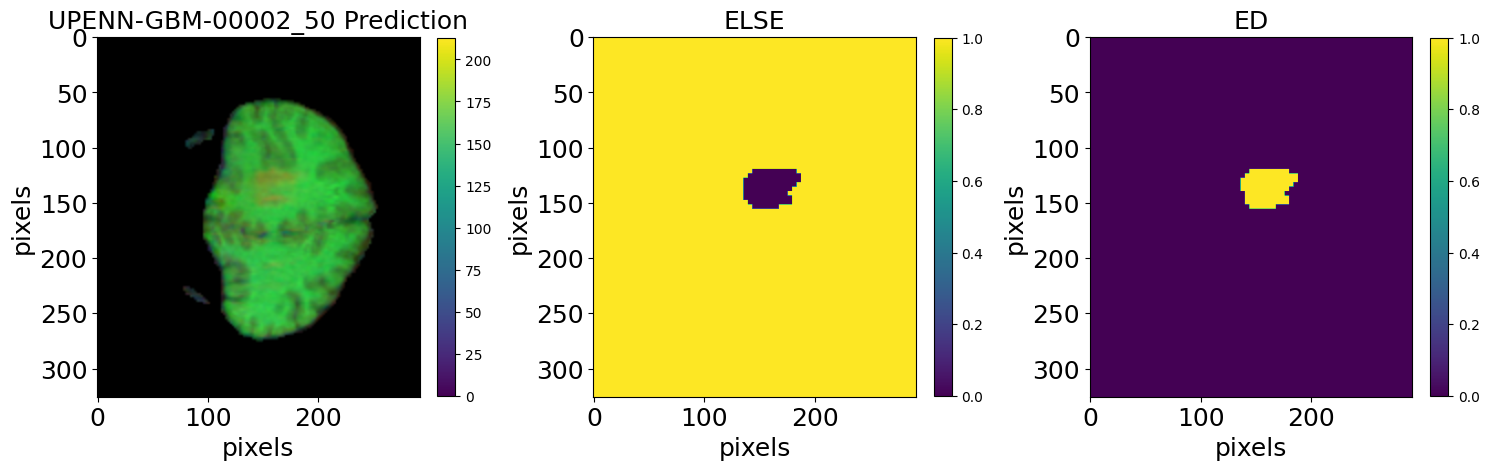

In [266]:
# QC predicted masks with segmentation with Maskformer resolution

# this will convert post_process_semantic_segmentation to masks so the format is similar with the maskformer input
pred_mask_labels, pred_class_labels = get_mask_from_segm_result(segm_result=results)
input_class_labels = test_class_labels.numpy()

# the conversion will allow us to compare the two side by side
mf_utils.plot_mask_labels(class_labels= input_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = test_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = pred_mask_labels,
             title= test_subj + " Prediction")


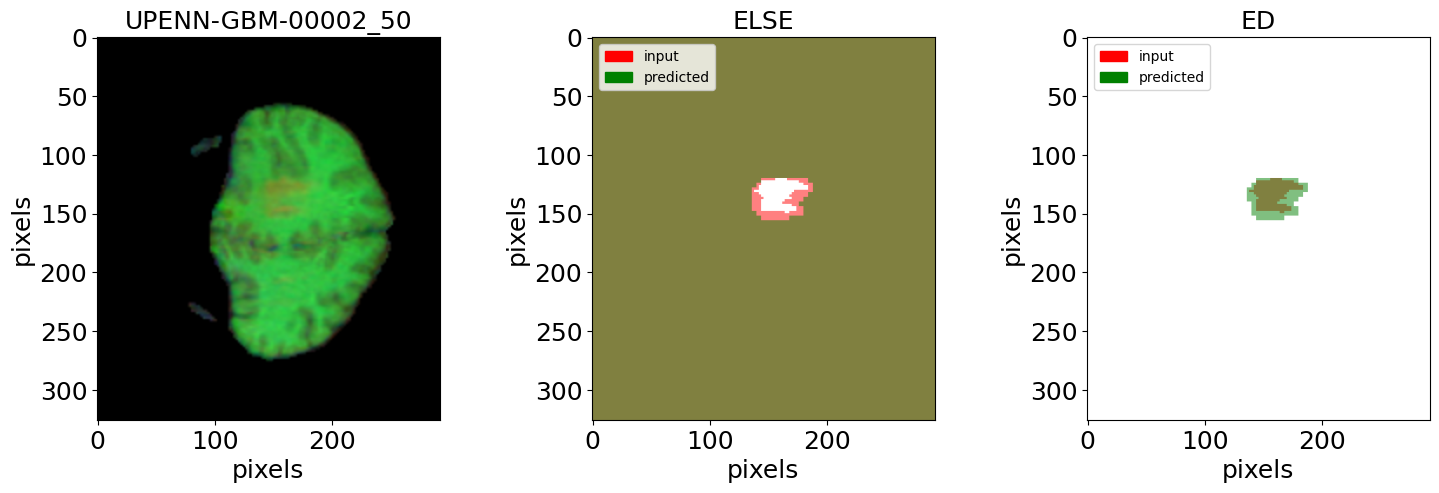

In [267]:
# plot predicted segment over of input segment.
# note: if a segment is predicted but does not exist in the input mask, it will not show here

mf_utils.plot_mask_comparison(input_class_labels=input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=test_image.numpy(),
                     input_mask_labels=test_mask_labels,
                     pred_mask_labels=pred_mask_labels,
                     title=test_subj)


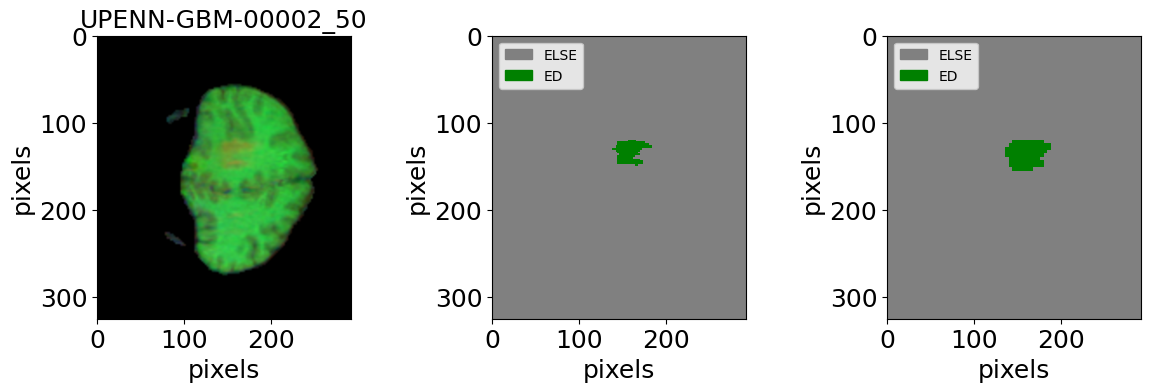

In [268]:
# mask_to_segmentation will flatten mask labels with shape  (n_label, width, height) to a segmentation image (width, height)
input_segmentation = mf_utils.mask_to_segmentation(mask_labels=test_mask_labels, class_labels=input_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels, class_labels=pred_class_labels)

mf_utils.plot_segmentation_comparison(
        input_pixel_values=test_image.numpy(),
        input_segmentation=input_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")

#### 4.1.2 Calculate metrics on predicted sample

In [269]:
# review dimensions and predicitios
all_labels = list(id2label.keys())
print("all segments:", all_labels)

print("\nlabels:")
input_class_labels = list(test_class_labels.numpy())
print("input_class_labels", input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape", test_mask_labels.shape)
print("pred_mask shape", pred_mask_labels.shape)
print("note that dimension changes based on the number of labels")


all segments: [0, 1, 2, 3]

labels:
input_class_labels [0, 2]
pred_class_labels [0, 2]

segmentation shapes:
true_mask shape torch.Size([2, 326, 292])
pred_mask shape (2, 326, 292)
note that dimension changes based on the number of labels


In [270]:
mask_shape = pred_mask_labels[0, :, :].shape

# loop through segments 0 to 3
for label_id in all_labels:

    print(f"Metrics for {label_id} - {id2label[label_id]}:")
    pred_mask = np.zeros(mask_shape, dtype=np.uint8)
    true_mask = np.zeros(mask_shape, dtype=np.uint8)

    if label_id in input_class_labels:
        # extract layer in test_mask_labels corresponding to the label
        true_mask_idx = input_class_labels.index(label_id)
        true_mask = test_mask_labels[true_mask_idx, :, :].numpy().squeeze().astype(np.uint8)

    if label_id in pred_class_labels:
        # extract layer in pred_mask_labels corresponding to the label
        pred_mask_idx = pred_class_labels.index(label_id)
        pred_scaled_mask = pred_mask_labels[pred_mask_idx, :, :].squeeze()
        pred_mask = mf_utils.descale_mask(pred_scaled_mask)

    # calculate metrics
    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)
    # print("Specificity", other_metrics["specificity"])
    # print("Sensitivity", other_metrics["sensitivity"])
    # print("Precision", other_metrics["precision"])
    # print("Recall", other_metrics["recall"])
    print()

Metrics for 0 - ELSE:
Dice Score 0.9961715160796325
HD95 5.656854249492381

Metrics for 1 - NCR:
Both images do not have this segment.
Dice Score 0
Both images do not have this segment.
HD95 inf

Metrics for 2 - ED:
Dice Score 0.704225352112676
HD95 9.230266291031075

Metrics for 3 - ET:
Both images do not have this segment.
Dice Score 0
Both images do not have this segment.
HD95 inf



#### 4.1.3 Visualize model output

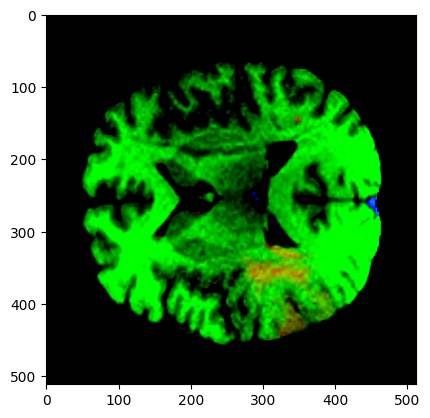

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


output keys: odict_keys(['loss', 'class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state', 'attentions'])
class_queries_logits shape: torch.Size([10, 100, 5])
masks_queries_logits shape: torch.Size([10, 100, 128, 128])
encoder_last_hidden_state shape: torch.Size([10, 768, 16, 16])
pixel_decoder_last_hidden_state shape: torch.Size([10, 256, 128, 128])
transformer_decoder_last_hidden_state shape: torch.Size([10, 100, 256])
len(attentions): 6
attentions[0]: torch.Size([10, 8, 100, 100])


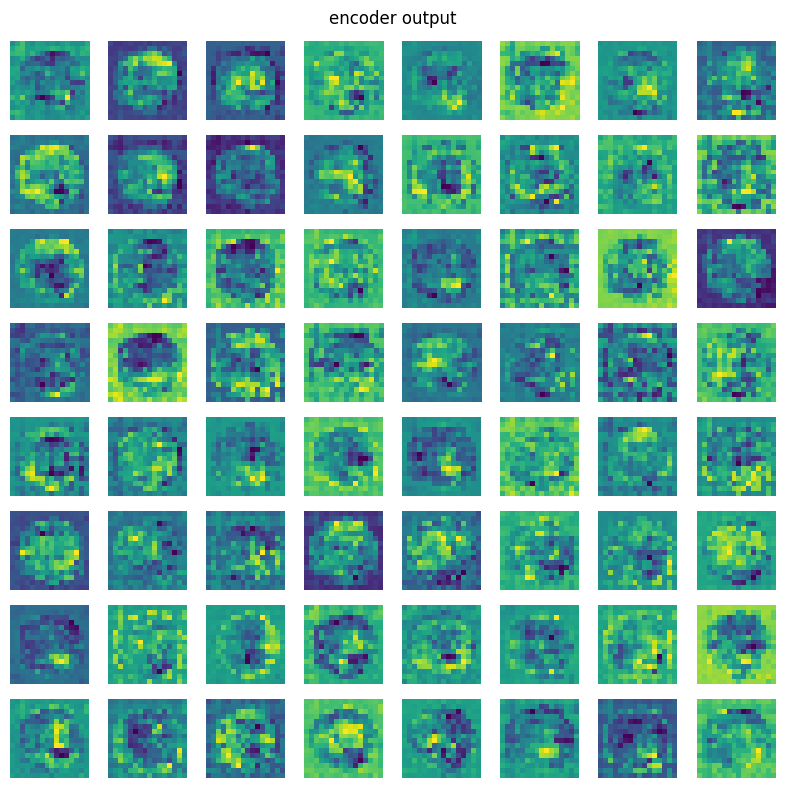

In [ ]:
# visualize the last layer of the encoder
n_row = 16
n_col = 16
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

In [ ]:
# visualize the last layer of the pixel decodeer
n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

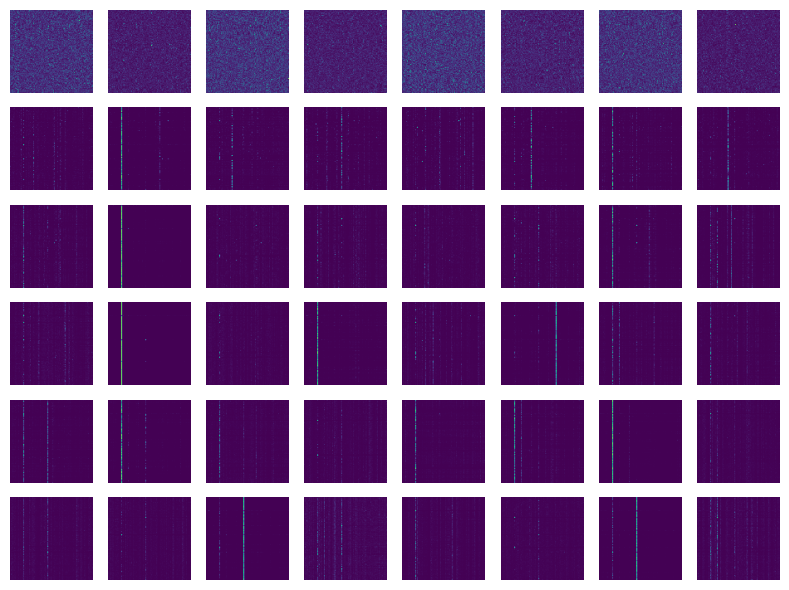

In [ ]:
# visualize the attention map
n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

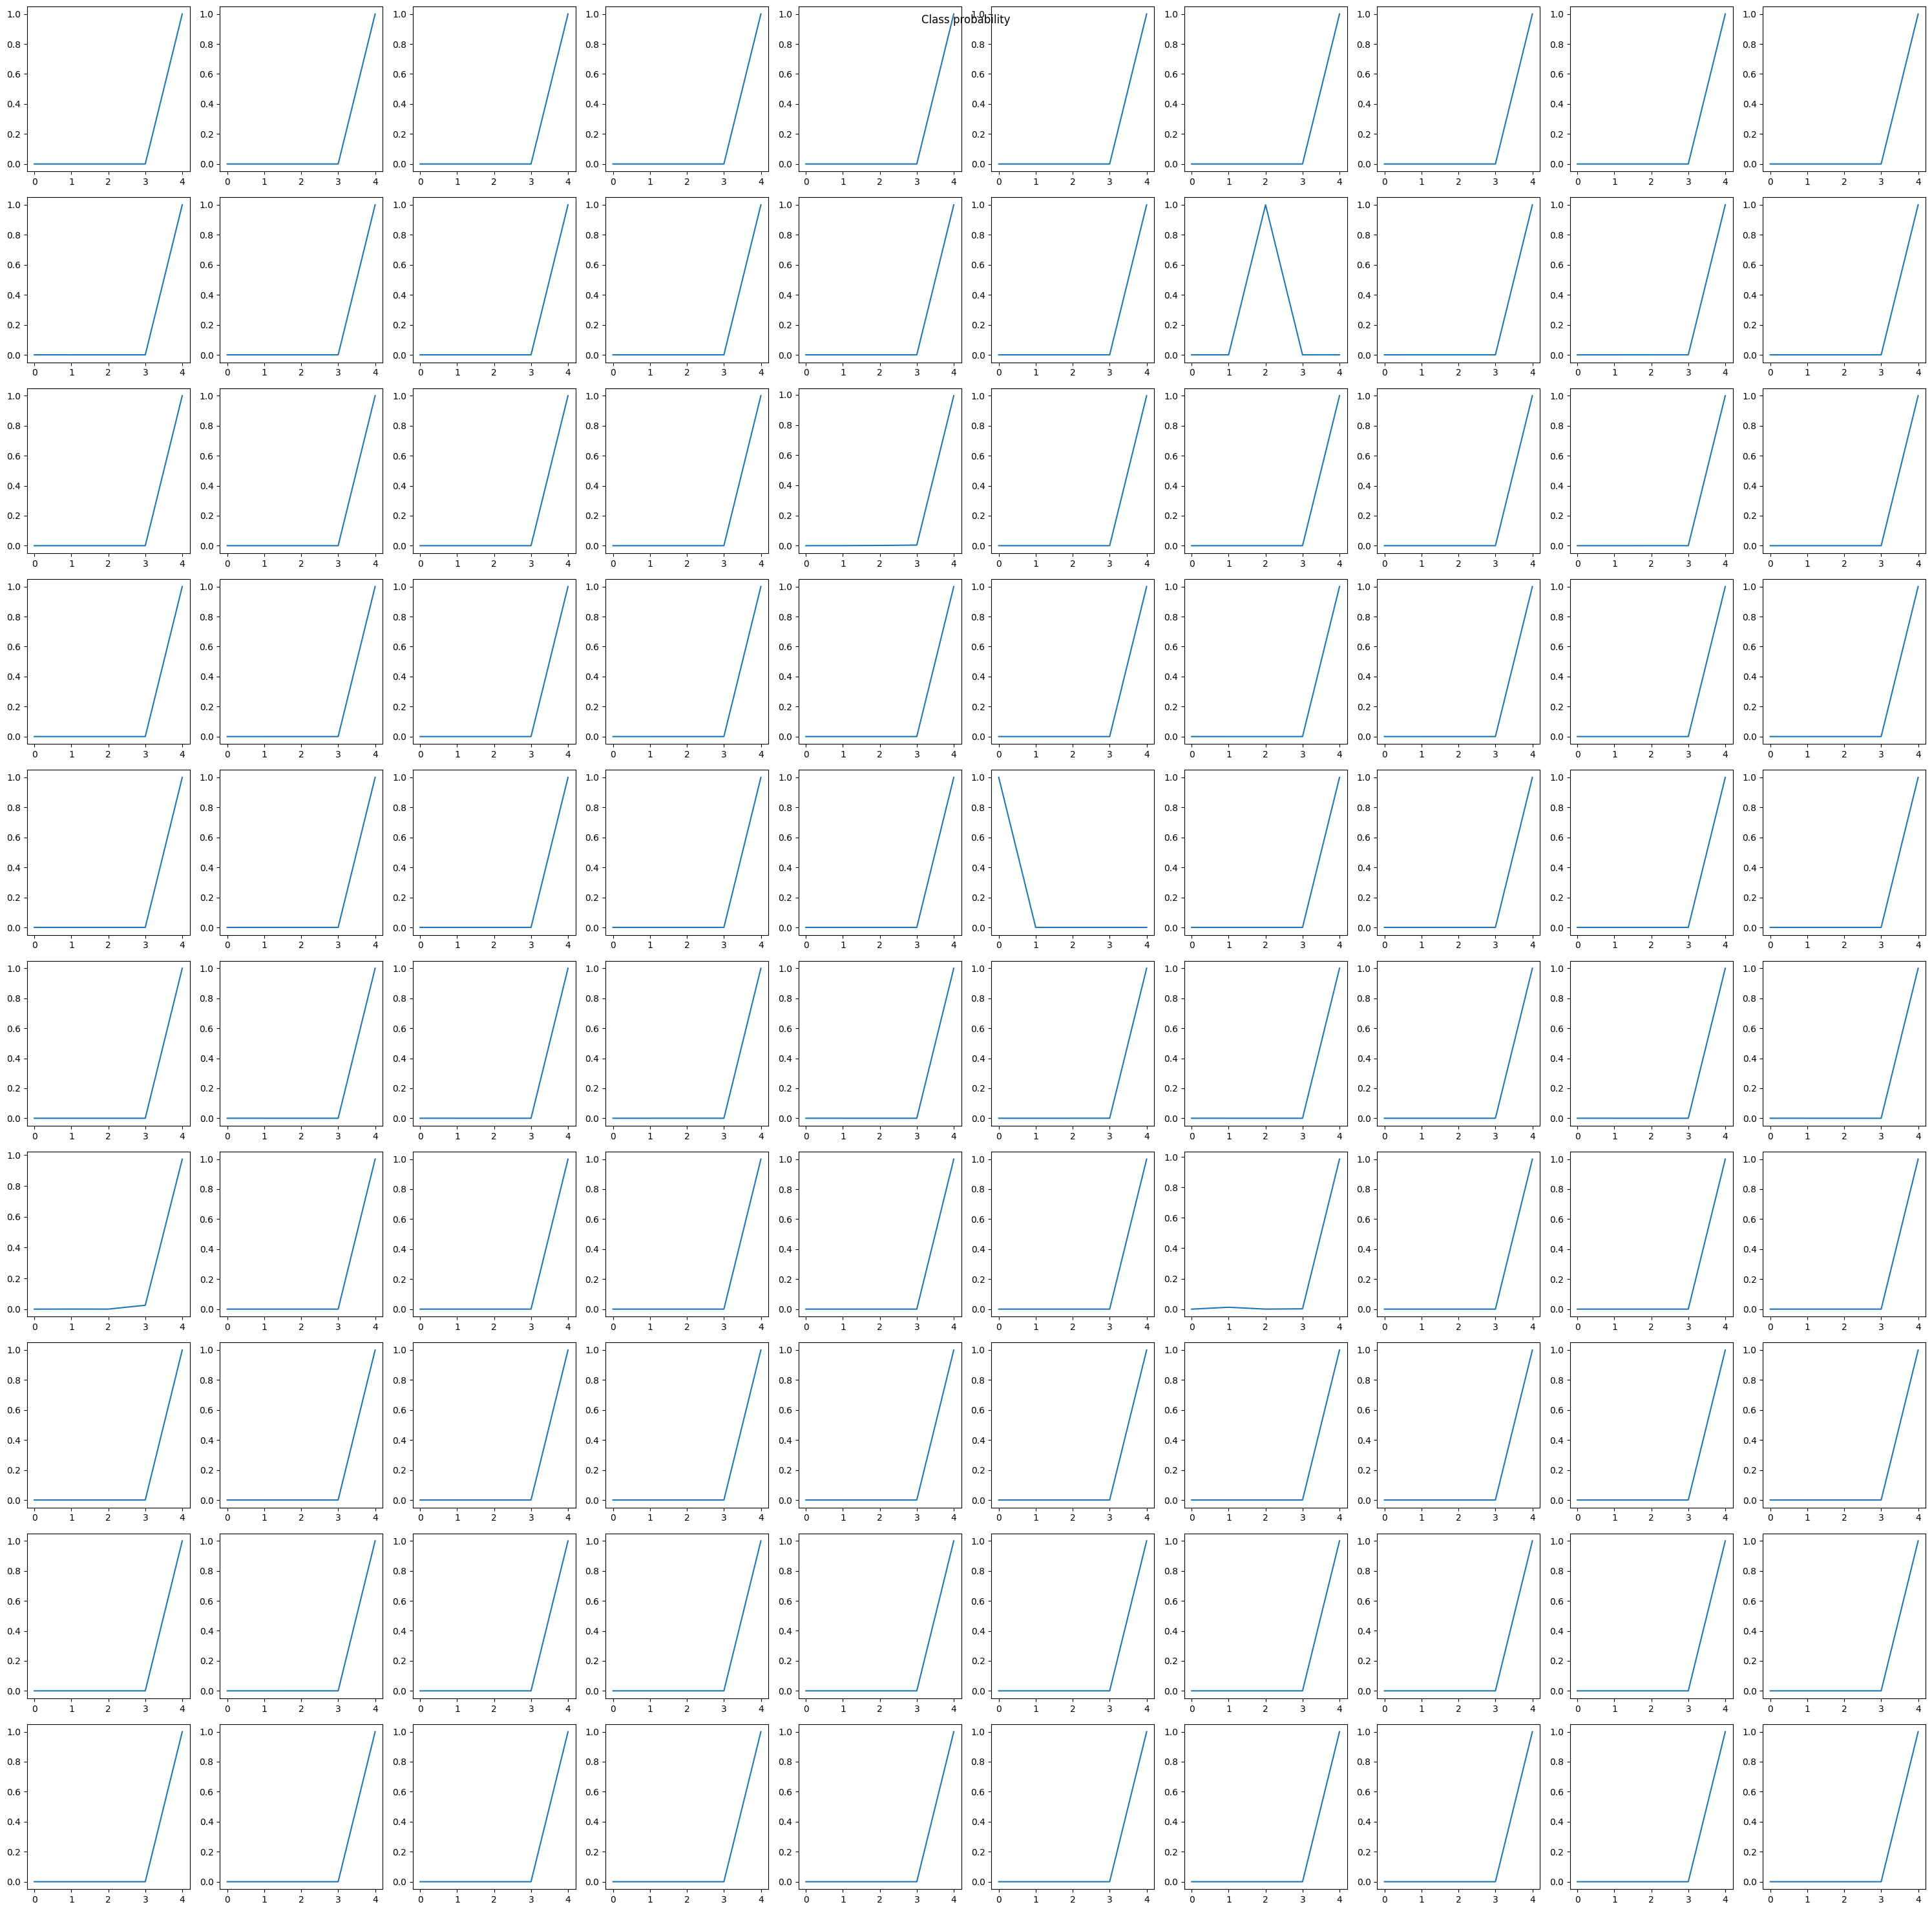

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = mf_utils.softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation
img_width = outputs.pixel_decoder_last_hidden_state.shape[-1]
img_height = outputs.pixel_decoder_last_hidden_state.shape[-2]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_width*img_height)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_height, img_width).numpy()

mask_pred_vis.shape

(100, 128, 128)

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

torch.Size([256, 16384])
torch.Size([100, 256])


In [ ]:
# visualize mask prediction
n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


torch.Size([128, 128])


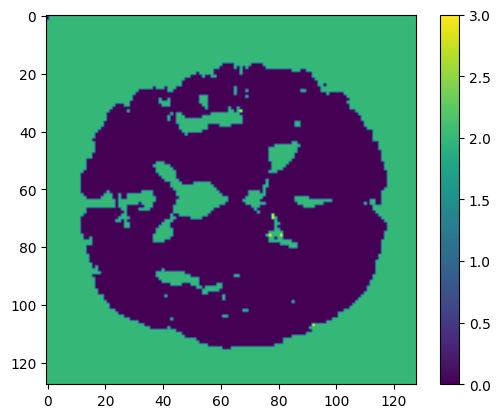

In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_width*img_height)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_height,img_width)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()
plt.show()

#### 4.1.4 QC Resized Transform

In [271]:
# previous target batch
target_batch

5

In [272]:
# obtain one batch of original data
# org_dataloader is the dataloader which has the original size of the image
for ibatch, batch in enumerate(org_dataloader):
    if ibatch == target_batch:
        org_batch = batch
        break
    else:
        continue

org_image =  org_batch["pixel_values"][test_idx]
org_pixel_mask = org_batch["pixel_mask"][test_idx]
org_mask_labels = org_batch["mask_labels"][test_idx]
org_class_labels = org_batch["class_labels"][test_idx]
org_subj = org_batch["subj_no"][test_idx] + "_" +  org_batch["file_no"][test_idx]
print(org_subj)

UPENN-GBM-00002_50


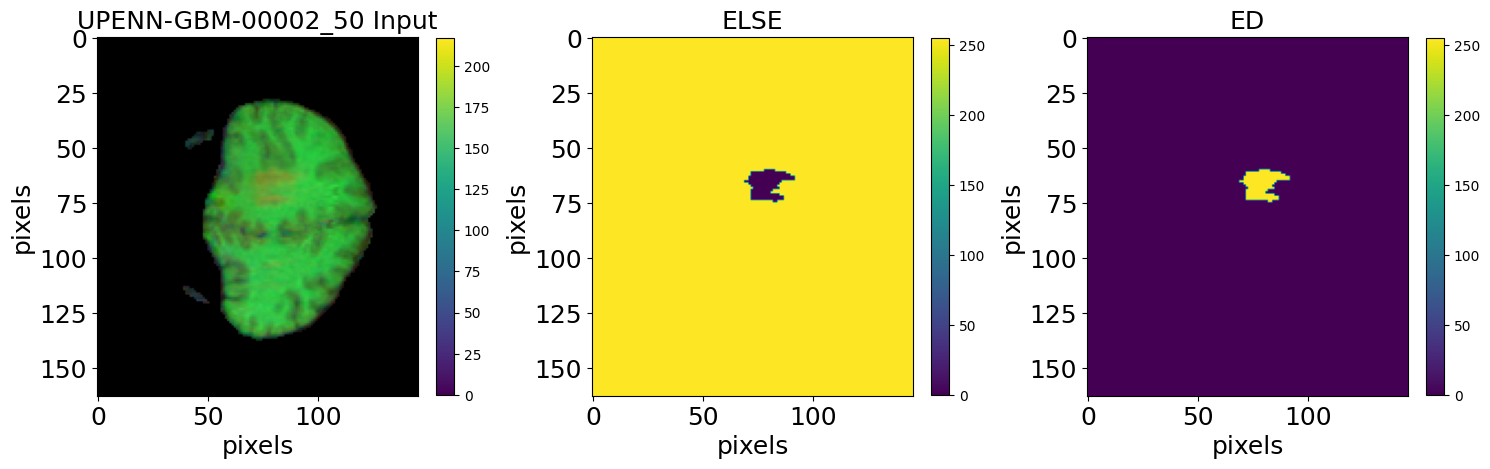

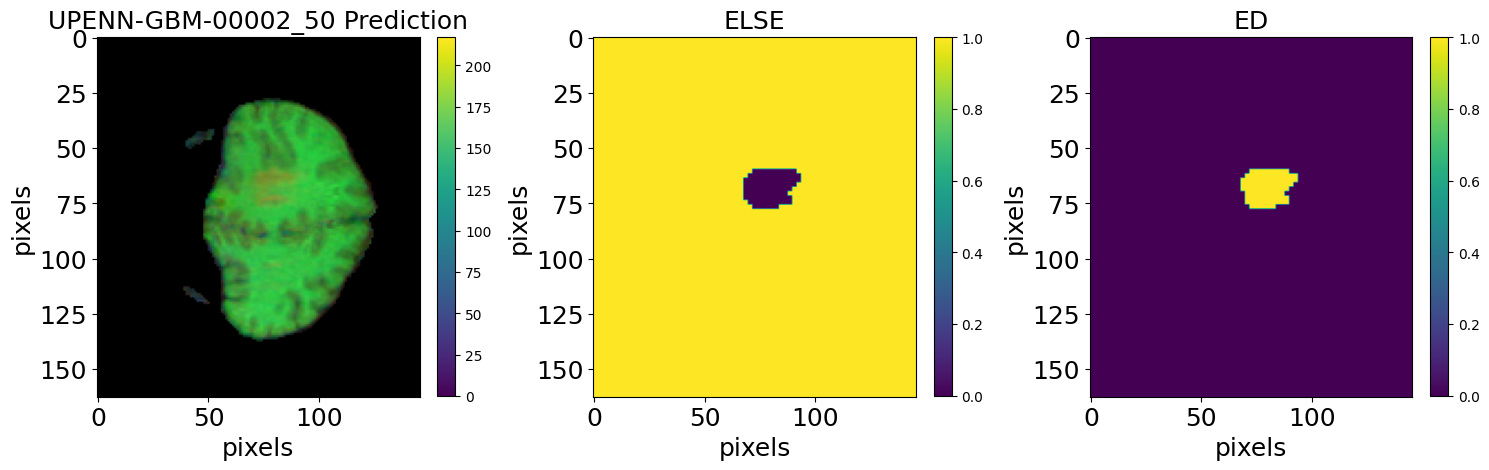

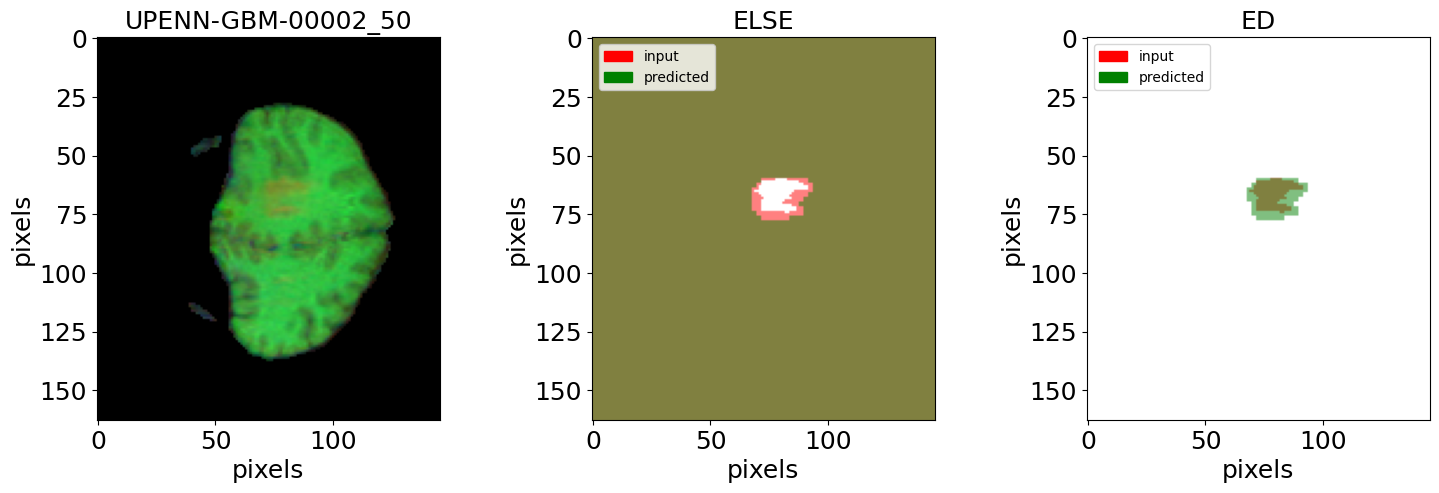

In [273]:
# resize predicted mask from 4.1.1 to original size
# re-run code from 4.1.1 (expected same output. just rewriting for readability/accessibility)
pred_mask_labels, pred_class_labels = get_mask_from_segm_result(segm_result=results)
pred_mask_labels_rs = mf_utils.resize_mask(pred_mask_labels, orig_dim)

# plot input mask labels
org_input_class_labels = org_class_labels.numpy()
mf_utils.plot_mask_labels(class_labels= org_input_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = org_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = pred_mask_labels_rs,
             title= test_subj + " Prediction")

mf_utils.plot_mask_comparison(input_class_labels=org_input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=org_image.numpy(),
                     input_mask_labels=org_mask_labels,
                     pred_mask_labels=pred_mask_labels_rs,
                     title=test_subj)


In [274]:
# or maybe used actual file
org_subj_id = org_batch["subj_no"][0]
org_file_id = org_batch["file_no"][0]

# compare to actual file
# org_segmentation = data_handler.load_mri("UPENN-GBM-00008", mri_type=MY_MRI_TYPE_VAL, file_no=80)
org_segmentation = data_handler.load_mri(target_subj, mri_type=MY_MRI_TYPE_TEST, file_no=test_file_no)

# this is the input mask from MaskFormer. confirmed to have the same segments as the actual file
# org_segmentation = mf_utils.mask_to_segmentation(mask_labels=org_mask_labels, class_labels=org_input_class_labels)

pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels_rs, class_labels=pred_class_labels)

print("orig segmentation shape", org_segmentation.shape)
print("pred segmentation shape", pred_segmentation.shape)

orig segmentation shape (163, 146)
pred segmentation shape (163, 146)


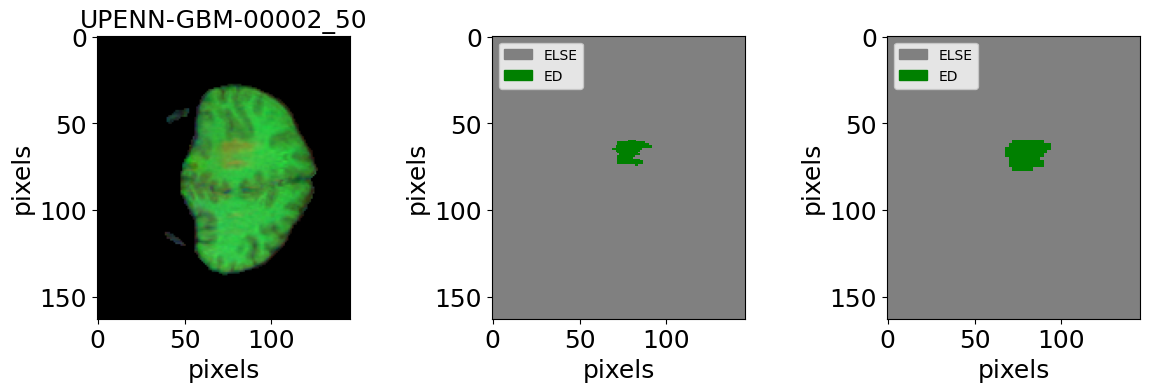

In [275]:
# plot the 2 segmentations
mf_utils.plot_segmentation_comparison(
        input_pixel_values=org_image.numpy(),
        input_segmentation=org_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")

#### 4.1.5 Calculate metrics on resized sample

In [276]:
# review dimensions and predictions
print("\nlabels:")
org_input_class_labels = list(org_class_labels.numpy())
print("org_class_labels", org_input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape (orig size)", org_mask_labels.shape)
print("pred_mask shape (resized to orig)", pred_mask_labels_rs.shape)
print("note that dimension changes based on the number of labels")


labels:
org_class_labels [0, 2]
pred_class_labels [0, 2]

segmentation shapes:
true_mask shape (orig size) torch.Size([2, 163, 146])
pred_mask shape (resized to orig) (2, 163, 146)
note that dimension changes based on the number of labels


In [277]:
mask_shape = pred_mask_labels_rs[0, :, :].shape

# loop through segments 0 to 3
for label_id in all_labels:

    print(f"Metrics for {label_id} - {id2label[label_id]}:")
    pred_mask = np.zeros(mask_shape, dtype=np.uint8)
    true_mask = np.zeros(mask_shape, dtype=np.uint8)

    if label_id in org_input_class_labels:
        # extract layer corresponding to the label
        true_mask_idx = org_input_class_labels.index(label_id)
        true_mask = org_mask_labels[true_mask_idx, :, :].numpy().squeeze().astype(np.uint8)

    if label_id in pred_class_labels:
        # get which layer/index corresponds to the label
        pred_mask_idx = pred_class_labels.index(label_id)
        pred_scaled_mask = pred_mask_labels_rs[pred_mask_idx, :, :].squeeze()
        pred_mask = mf_utils.descale_mask(pred_scaled_mask)

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)
    # print("Specificity", other_metrics["specificity"])
    # print("Sensitivity", other_metrics["sensitivity"])
    # print("Precision", other_metrics["precision"])
    # print("Recall", other_metrics["recall"])
    print()

Metrics for 0 - ELSE:
Dice Score 0.9961715160796325
HD95 2.8284271247461903

Metrics for 1 - NCR:
Both images do not have this segment.
Dice Score 0
Both images do not have this segment.
HD95 inf

Metrics for 2 - ED:
Dice Score 0.704225352112676
HD95 4.47213595499958

Metrics for 3 - ET:
Both images do not have this segment.
Dice Score 0
Both images do not have this segment.
HD95 inf



### 4.2 Make predictions on all data and compute metrics

#### 4.2.0 Initialize variables

In [278]:
# prepare inference class to perform prediction

# ORIGINAL EVALUATION
# define a transform for upscaled predictions
predict_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])


mf_test_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_TEST,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)
print("total test files", len(mf_test_inference.all_files))

mf_val_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_VAL,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)
print("total validation files", len(mf_val_inference.all_files))

mf_train_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_TRAIN,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)

print("total training files", len(mf_train_inference.all_files))

total test files 5597
total validation files 5790
total training files 16984


In [279]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

predict_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

mf_eval=MaskFormerEvaluation()

# note: scale_to_orig_size is True by default since this is what will be using moving forward.
# Im just making it explicit here
mf_test_inference_upscaled=MaskFormerInference(data_handler=data_handler,
                                              data_identifier=MY_MRI_TYPE_TEST,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=predict_transform,
                                              orig_transform=org_transform,
                                              scale_to_orig_size=True,
                                              orig_dim=orig_dim)

print("total test files", len(mf_test_inference.all_files))

mf_val_inference_upscaled=MaskFormerInference(data_handler=data_handler,
                                              data_identifier=MY_MRI_TYPE_VAL,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=predict_transform,
                                              orig_transform=org_transform,
                                              scale_to_orig_size=True,
                                              orig_dim=orig_dim)

print("total validation files", len(mf_val_inference.all_files))

mf_train_inference_upscaled=MaskFormerInference(data_handler=data_handler,
                                            data_identifier=MY_MRI_TYPE_TRAIN,
                                            model=model,
                                            processor=processor,
                                            upscaled_transform=predict_transform,
                                            orig_transform=org_transform,
                                            scale_to_orig_size=True,
                                            orig_dim=orig_dim)

print("total training files", len(mf_train_inference.all_files))

total test files 5597
total validation files 5790
total training files 16984


#### 4.2.1 Predict for 1 patient (3d volume) - not resized

In [ ]:
# record start time
start_time = time.time()
pred_target_subj = "UPENN-GBM-00131"
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference.predict_patient_mask(subj_id=pred_target_subj)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))

# convert from 255 to 0-1
mask_pred_3d_binary = mf_utils.descale_mask(mask_pred_3d)
mask_true_3d_binary = mf_utils.descale_mask(mask_true_3d)

# instantiate evaluation function to calculate metrics
start_time = time.time()
mf_eval=MaskFormerEvaluation()
print("mask_pred_3d_binary shape", mask_pred_3d_binary.shape)
print("mask_true_3d_binary shape", mask_true_3d_binary.shape)

# hausdorff takes 32 seconds
dice_score, hausdorff, common_metrics_dict = mf_eval.calc_metrics(subj_id=pred_target_subj,
                        mask_pred_binary=mask_pred_3d_binary,
                        mask_true_binary=mask_true_3d_binary)

end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))


print("dice_score", dice_score)
print("hausdorff_val", hausdorff)
print("sensitivity", common_metrics_dict['sensitivity'])
print("specificity", common_metrics_dict['specificity'])

Performing inference on UPENN-GBM-00131
batch size 10
Elapsed time: 9.575680 seconds
mask_pred_3d_binary shape (4, 146, 512, 512)
mask_true_3d_binary shape (4, 146, 512, 512)
Calculating metrics for  UPENN-GBM-00131
Elapsed time: 34.678209 seconds
dice_score [0.9990568820015747, 0.8971762058046112, 0.885810182322155, 0.820561858254266]
hausdorff_val [1.0, 3.0, 3.0, 2.0]
sensitivity [0.9985346507791174, 0.8993651293352222, 0.8517596535758389, 0.8436032527774596]
specificity [0.9599809768728093, 0.9998948081629911, 0.9994231435361167, 0.9997086652504336]


#### 4.2.2 Predict for 1 patient (3d volume) - use original size

In [ ]:
# note: scale_to_orig_size is True by default. Im just making it explicit here
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference_upscaled.predict_patient_mask(subj_id=pred_target_subj)

# convert from 255 to 0-1
mask_pred_3d_binary = mf_utils.descale_mask(mask_pred_3d)
mask_true_3d_binary = mf_utils.descale_mask(mask_true_3d)

# instantiate evaluation function to calculate metrics
mf_eval=MaskFormerEvaluation()
orig_dice_score, orig_hausdorff, orig_common_metrics = mf_eval.calc_metrics(subj_id=pred_target_subj,
                        mask_pred_binary=mask_pred_3d_binary,
                        mask_true_binary=mask_true_3d_binary)



Performing inference on UPENN-GBM-00131
batch size 10
Calculating metrics for  UPENN-GBM-00131


#### 4.2.3 Put the metrics side by side

TODO: do further investigation here

In [ ]:
print("upscaled dice_score", dice_score)
print("orig dice_score", orig_dice_score)
print("")
print("upscaled hausdorff", hausdorff)
print("orig hausdorff", orig_hausdorff)
print("")
print("upscaled sensitivity", common_metrics_dict['sensitivity'])
print("orig sensitivity", orig_common_metrics['sensitivity'])
print("")
print("upscaled ", common_metrics_dict['specificity'])
print("orig specificity", orig_common_metrics['specificity'])


upscaled dice_score [0.9990568820015747, 0.8971762058046112, 0.885810182322155, 0.820561858254266]
orig dice_score [0.9989767627070124, 0.8448087431693989, 0.8697613442535136, 0.7336027354678272]

upscaled hausdorff [1.0, 3.0, 3.0, 2.0]
orig hausdorff [0.0, 1.4142135623730951, 2.0, 1.4142135623730951]

upscaled sensitivity [0.9985346507791174, 0.8993651293352222, 0.8517596535758389, 0.8436032527774596]
orig sensitivity [0.9984483005558001, 0.8437022484173761, 0.8375641408519534, 0.7538731831975722]

upscaled  [0.9599809768728093, 0.9998948081629911, 0.9994231435361167, 0.9997086652504336]
orig specificity [0.952931305715784, 0.9998465707137927, 0.9992853664066462, 0.9995885978599676]


#### 4.2.4  Obtain Validation datalist

In [131]:
# Obtain all validation subjects
val_subjs = mf_utils.get_all_subj_ids(data_handler=data_handler, mri_type=MY_MRI_TYPE_VAL)
print("total validation data", len(val_subjs))
print("first 5 validation subjects")
val_subjs[:5]

total validation data 30
first 5 validation subjects


['UPENN-GBM-00008',
 'UPENN-GBM-00013',
 'UPENN-GBM-00020',
 'UPENN-GBM-00030',
 'UPENN-GBM-00033']

In [280]:
# Obtain all test subjects
test_subjs = mf_utils.get_all_subj_ids(data_handler=data_handler, mri_type=MY_MRI_TYPE_TEST)
print("total test data", len(test_subjs))
print("first 5 test subjects")
test_subjs[:5]

total test data 29
first 5 test subjects


['UPENN-GBM-00002',
 'UPENN-GBM-00014',
 'UPENN-GBM-00026',
 'UPENN-GBM-00059',
 'UPENN-GBM-00062']

#### 4.2.5 Calculate Metrics for Validation Data

In [ ]:
# ORIGINAL EVALUATION, compares upscaled masks
print("val metrics_file_name: ", val_metrics_file_name)
val_metrics_dict, val_error_files, val_success_files = mf_eval.predict_and_eval(subj_names=val_subjs,
                                                                                data_handler=data_handler,
                                                                                mf_inference=mf_val_inference,
                                                                                metrics_dir_prefix=metrics_dir_prefix,
                                                                                metrics_file_name=val_metrics_file_name,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

val metrics_file_name:  metrics_val_epoch40_all_ju29.joblib
Performing inference on UPENN-GBM-00008
Calculating metrics for  UPENN-GBM-00008
Performing inference on UPENN-GBM-00013
Calculating metrics for  UPENN-GBM-00013
Performing inference on UPENN-GBM-00020
Calculating metrics for  UPENN-GBM-00020
Performing inference on UPENN-GBM-00030
Calculating metrics for  UPENN-GBM-00030
Performing inference on UPENN-GBM-00033
Calculating metrics for  UPENN-GBM-00033
Performing inference on UPENN-GBM-00054
Calculating metrics for  UPENN-GBM-00054
Performing inference on UPENN-GBM-00075
Calculating metrics for  UPENN-GBM-00075
Performing inference on UPENN-GBM-00086
Calculating metrics for  UPENN-GBM-00086
Performing inference on UPENN-GBM-00100
Calculating metrics for  UPENN-GBM-00100
Performing inference on UPENN-GBM-00101
Calculating metrics for  UPENN-GBM-00101
Performing inference on UPENN-GBM-00105
Calculating metrics for  UPENN-GBM-00105
Performing inference on UPENN-GBM-00118
Calculati

In [ ]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
print("val metrics_file_name: ", "upscaled_"+val_metrics_file_name)
val_metrics_dict_upscaled, val_error_files_upscaled, val_success_files_upscaled = mf_eval.predict_and_eval(subj_names=val_subjs,
                                                                                data_handler=data_handler,
                                                                                mf_inference=mf_val_inference_upscaled,
                                                                                metrics_dir_prefix=metrics_dir_prefix,
                                                                                metrics_file_name="upscaled_"+val_metrics_file_name,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

val metrics_file_name:  upscaled_metrics_val_epoch40_all_ju29.joblib
Performing inference on UPENN-GBM-00008
Calculating metrics for  UPENN-GBM-00008
Performing inference on UPENN-GBM-00013
Calculating metrics for  UPENN-GBM-00013
Performing inference on UPENN-GBM-00020
Calculating metrics for  UPENN-GBM-00020
Performing inference on UPENN-GBM-00030
Calculating metrics for  UPENN-GBM-00030
Performing inference on UPENN-GBM-00033
Calculating metrics for  UPENN-GBM-00033
Performing inference on UPENN-GBM-00054
Calculating metrics for  UPENN-GBM-00054
Performing inference on UPENN-GBM-00075
Calculating metrics for  UPENN-GBM-00075
Performing inference on UPENN-GBM-00086
Calculating metrics for  UPENN-GBM-00086
Performing inference on UPENN-GBM-00100
Calculating metrics for  UPENN-GBM-00100
Performing inference on UPENN-GBM-00101
Calculating metrics for  UPENN-GBM-00101
Performing inference on UPENN-GBM-00105
Calculating metrics for  UPENN-GBM-00105
Performing inference on UPENN-GBM-00118


#### 4.2.6 Evaluate Validation Data

##### Summary statistics

In [ ]:
# ORIGINAL EVALUATION, compares upscaled masks
mf_eval.display_statistics(val_metrics_dict)

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.999147   0.752600   0.878849   0.820638
std     0.000669   0.205911   0.097685   0.105630
min     0.997056   0.000000   0.507713   0.480183
25%     0.998959   0.735144   0.854998   0.800254
50%     0.999275   0.805973   0.914481   0.846888
75%     0.999597   0.844474   0.946172   0.881113
max     0.999819   0.956097   0.967391   0.939956


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.997848   0.747748   0.796287   0.810619
std     0.001571   0.185442   0.143494   0.130034
min     0.991037   0.000000   0.274784   0.369718
25%     0.997693   0.721686   0.777046   0.819587
50%     0.998255   0.802127   0.830763   0.849285
75%     0.998730   0.850745   0.868816   0.870285
max     0.999427   0.925368   0.930569   0.934197


Summary: sensitivity
            ELSE        NCR         ED  

In [ ]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
mf_eval.display_statistics(val_metrics_dict_upscaled)

Summary: precision
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.999005   0.718879   0.862472   0.781731
std     0.000694   0.200240   0.098815   0.108270
min     0.996944   0.000000   0.475488   0.433333
25%     0.998872   0.689038   0.830668   0.774828
50%     0.999140   0.747754   0.892591   0.806114
75%     0.999498   0.820495   0.928749   0.834350
max     0.999744   0.935104   0.959960   0.909707


Summary: recall
            ELSE        NCR         ED         ET
count  30.000000  30.000000  30.000000  30.000000
mean    0.997721   0.713322   0.781133   0.773365
std     0.001564   0.181221   0.142184   0.123977
min     0.991229   0.000000   0.277376   0.367925
25%     0.997389   0.697316   0.770550   0.783393
50%     0.998117   0.740310   0.816444   0.801387
75%     0.998555   0.824547   0.852406   0.825463
max     0.999384   0.894632   0.932544   0.915897


Summary: sensitivity
            ELSE        NCR         ED  

Final report metric summary

In [ ]:
val_mean_scores = mf_eval.get_mean_scores(val_metrics_dict)
val_mean_scores

,ELSE,NCR,ED,ET
dice_score,0.998497,0.739360,0.831123,0.809992
hd95,1.174721,12.563402,12.698962,4.670576
sensitivity,0.997848,0.747748,0.796287,0.810619
specificity,0.927392,0.999717,0.999050,0.999566


In [ ]:
val_mean_scores_upscaled = mf_eval.get_mean_scores(val_metrics_dict_upscaled)
val_mean_scores_upscaled

,ELSE,NCR,ED,ET
dice_score,0.998362,0.705943,0.815530,0.772341
hd95,0.837437,4.290318,4.985475,1.632731
sensitivity,0.997721,0.713322,0.781133,0.773365
specificity,0.918878,0.999667,0.998913,0.999458


Box plots

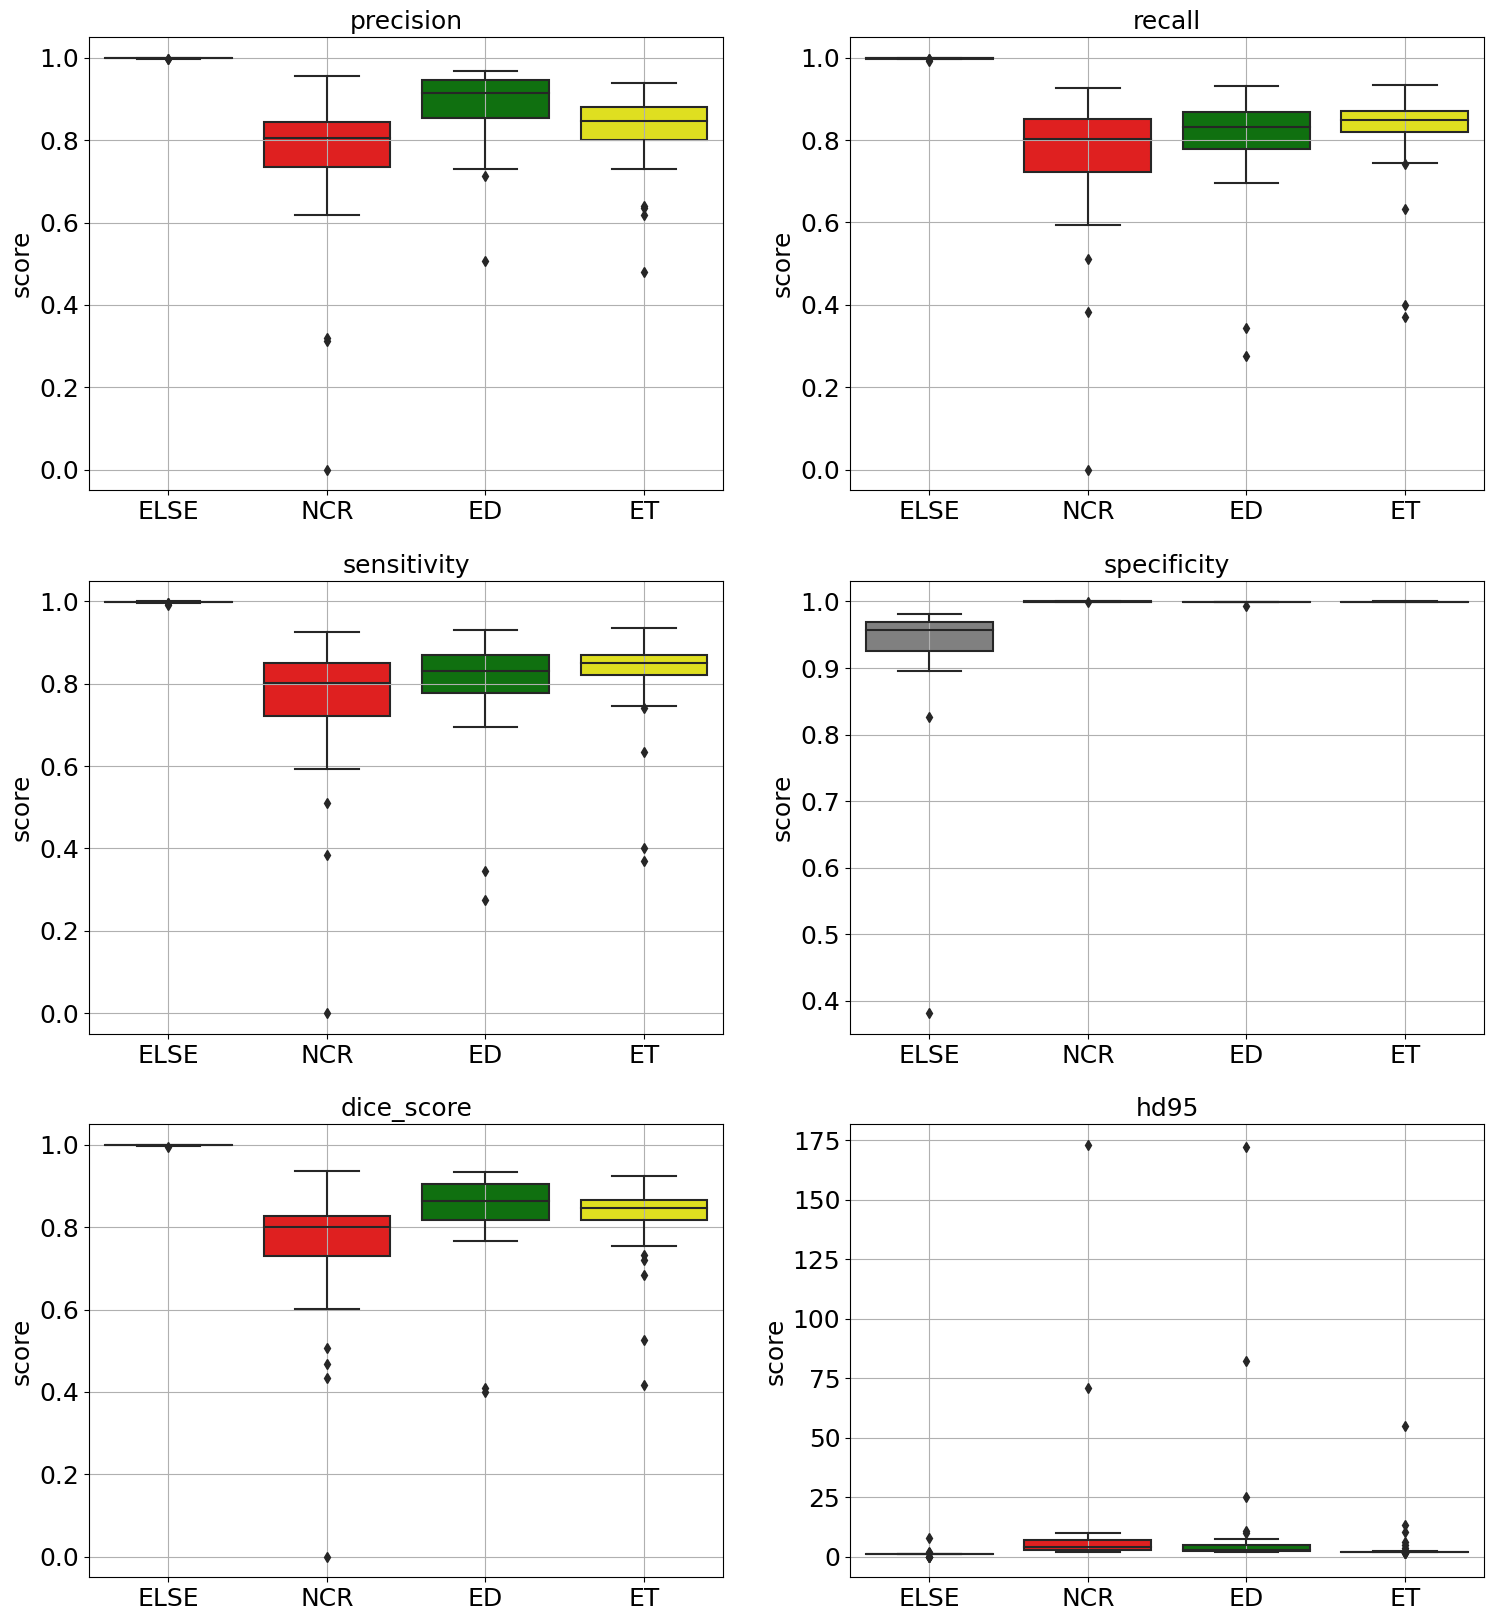

In [ ]:
mf_eval.draw_box_plots(val_metrics_dict)

Histograms

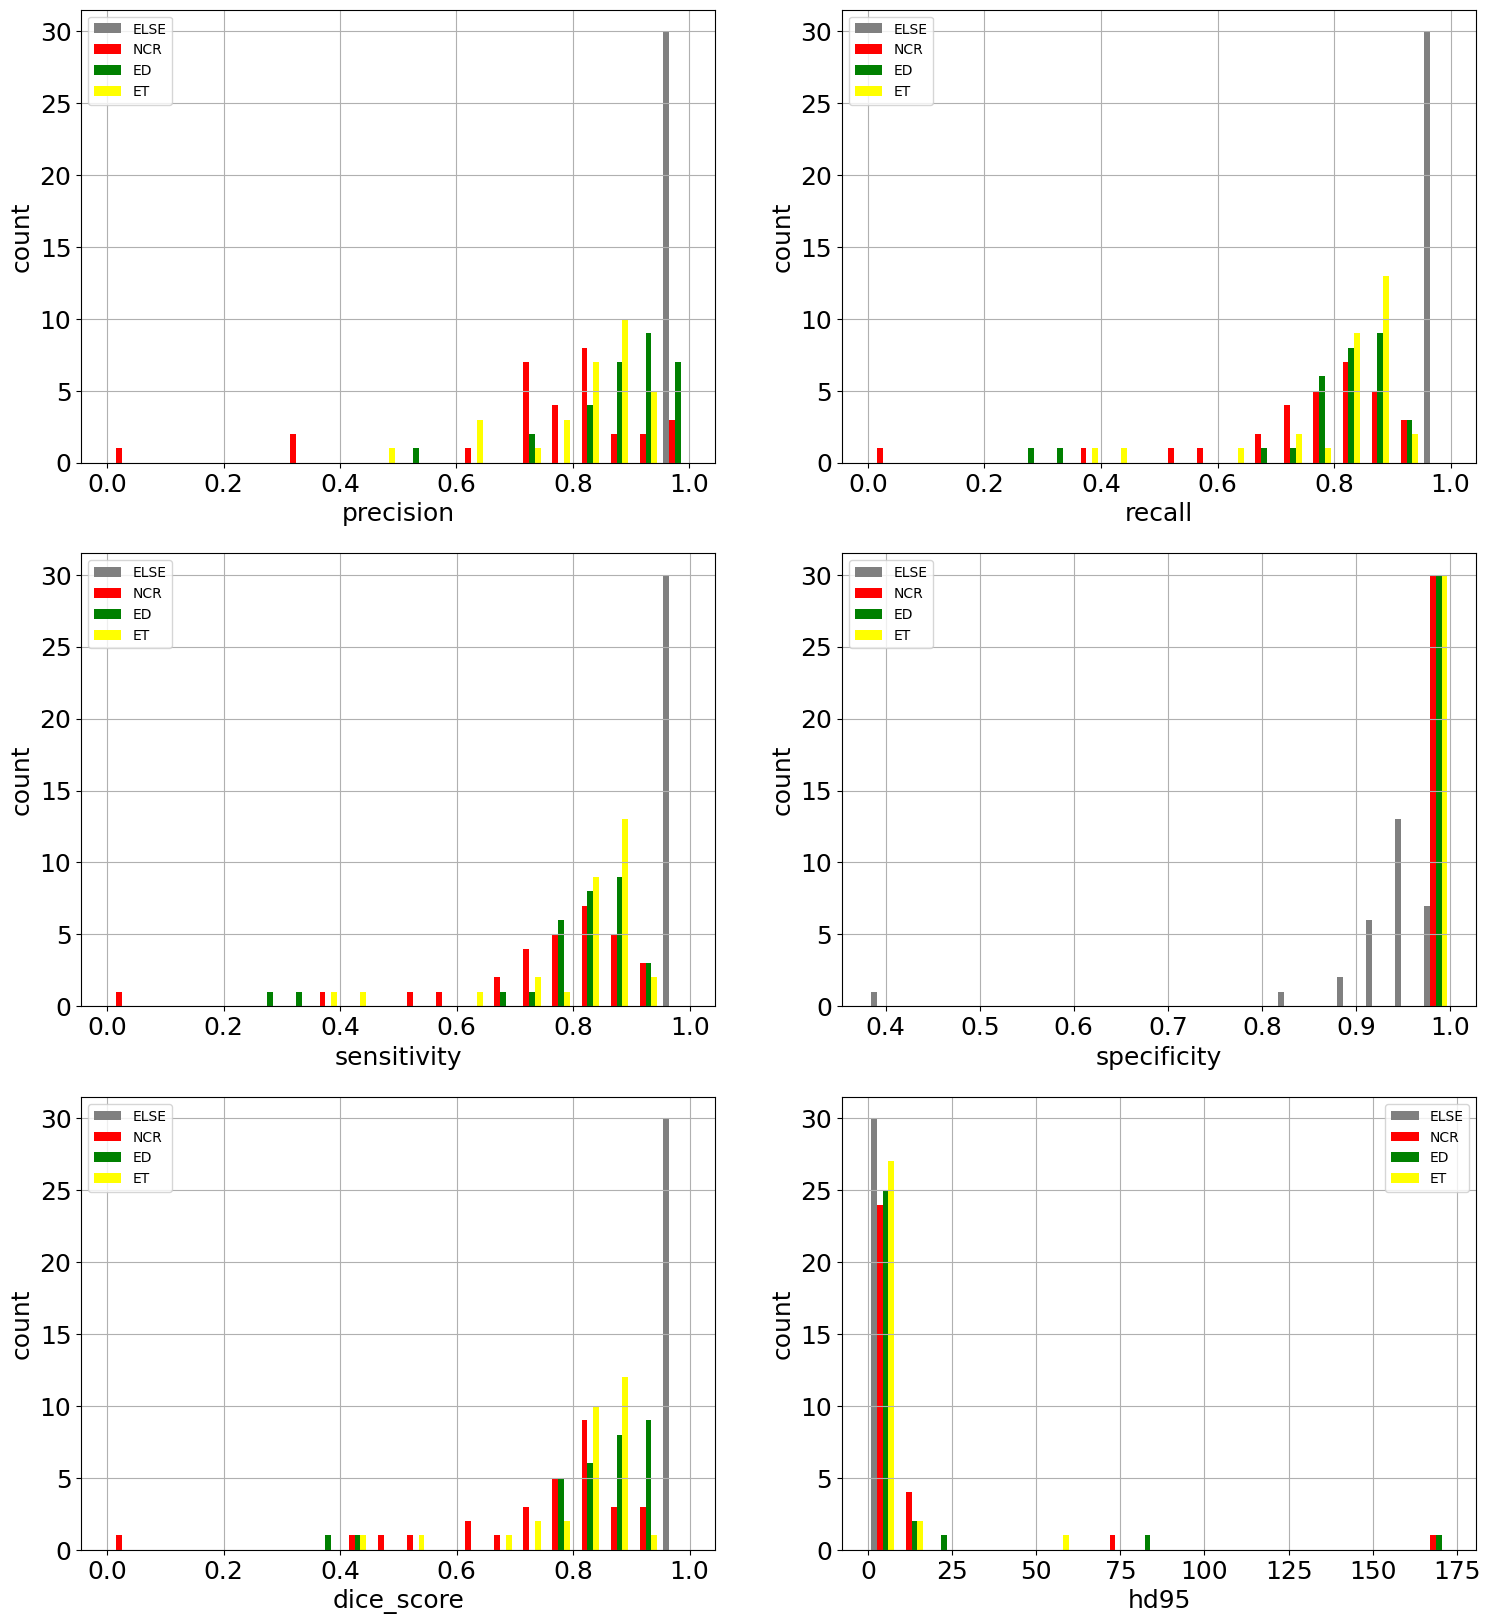

In [ ]:
mf_eval.build_histogram(val_metrics_dict)

##### Worst Dice Score

In [ ]:
# column label id corresponds to the specific segment which got the lowest score: i.e. Label 1 = NCR
low_dice_score_val = mf_eval.get_low_dice_score_images(val_success_files, val_metrics_dict, top_n=5)
low_dice_score_val

,subj_name,dataset_idx,label_id,score
0,UPENN-GBM-00380,27,1,0.000000
1,UPENN-GBM-00380,27,2,0.399368
2,UPENN-GBM-00240,20,2,0.410280
3,UPENN-GBM-00380,27,3,0.417772
4,UPENN-GBM-00474,29,1,0.432611


##### Worst HD95

In [ ]:
high_hd95_val = mf_eval.get_high_hd95_images(val_subjs, val_metrics_dict, top_n=5)
high_hd95_val

,subj_name,dataset_idx,label_id,score
0,UPENN-GBM-00380,27,1,173.039237
1,UPENN-GBM-00380,27,2,172.039237
2,UPENN-GBM-00206,18,2,82.134037
3,UPENN-GBM-00439,28,1,71.007032
4,UPENN-GBM-00261,24,3,54.711056


##### Plot image with low dice score

In [ ]:
low_dice_img = low_dice_score_val.loc[0]['subj_name']

# record start time
start_time = time.time()
image_3d, mask_true_3d, mask_pred_3d, true_class_labels, pred_class_labels = mf_val_inference_upscaled.predict_patient_mask(subj_id=low_dice_img)
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.6f} seconds".format(elapsed_time))

Performing inference on UPENN-GBM-00380
Elapsed time: 22.634336 seconds


Slice 55


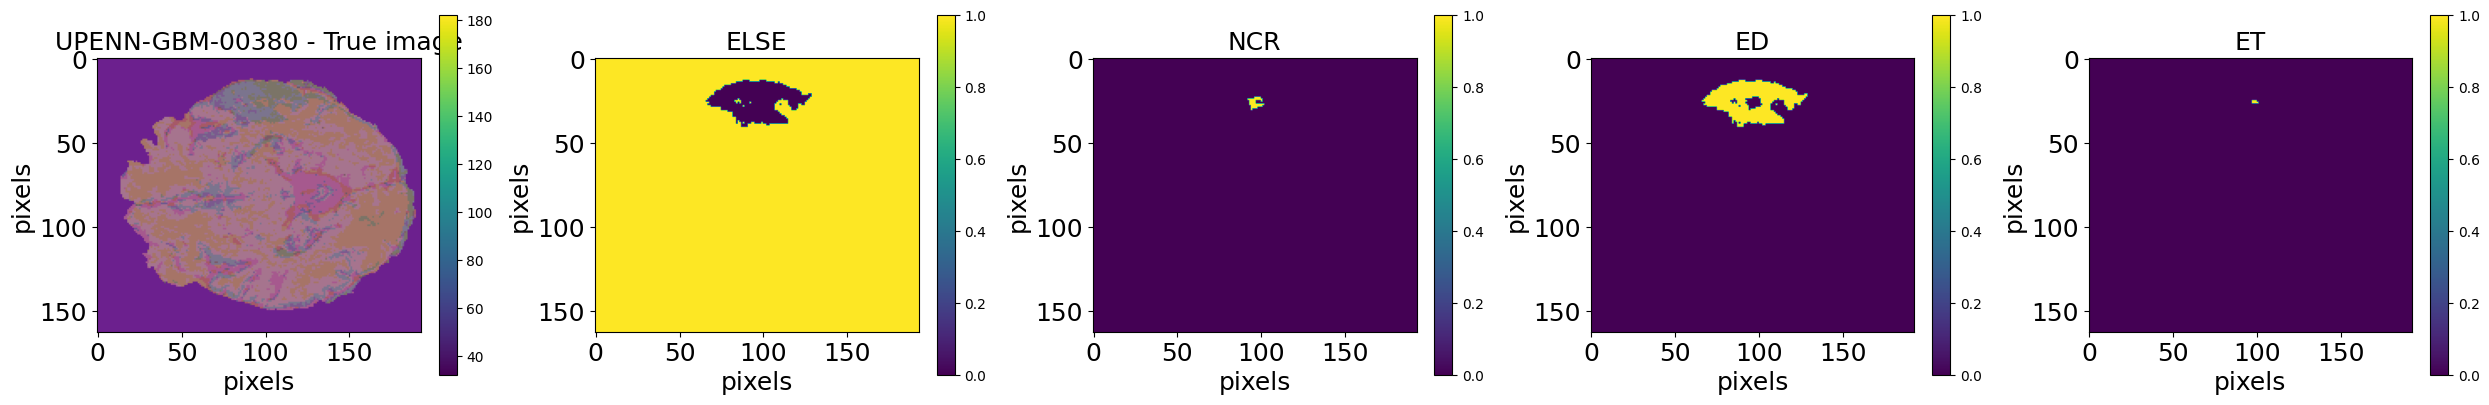

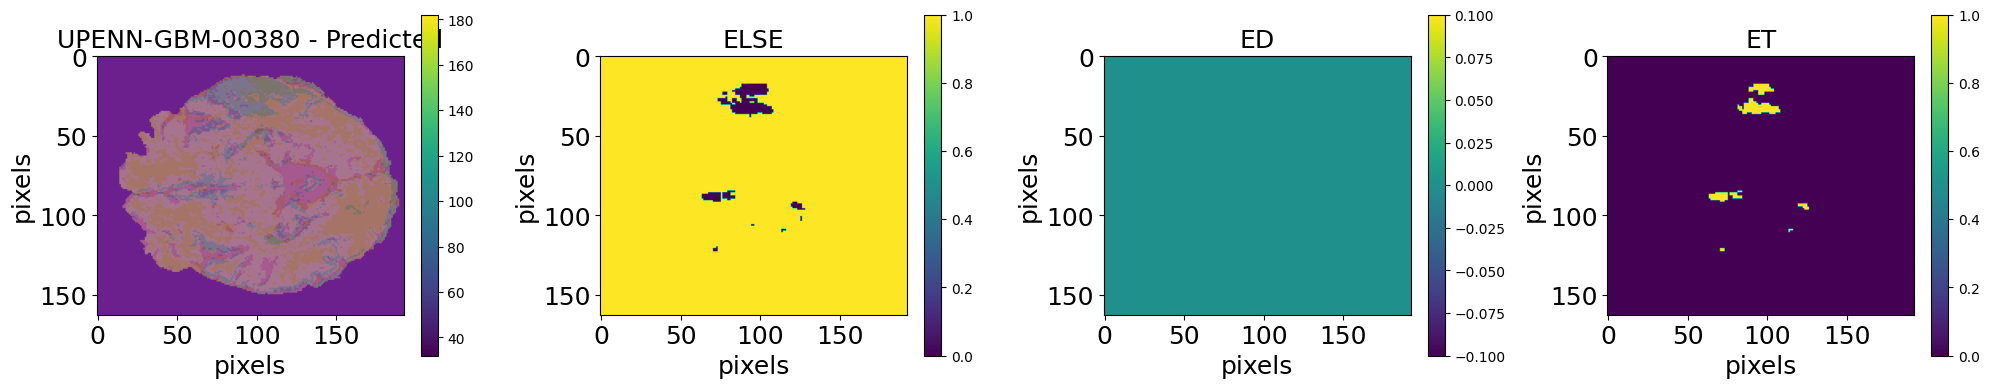

In [ ]:
# load annotated file
actual_file = data_handler.load_mri(low_dice_img, mri_type=MriType.ANNOTATED_REDUCED)

# get largest tumor slice for visualization
slice_idx = mri_common.get_largest_tumor_slice_idx(actual_file)[0]

print("Slice", slice_idx)
mf_utils.plot_mask_labels(class_labels = true_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_true_3d[:, slice_idx, :, :],
             title = f"{low_dice_img} - True image",)

mf_utils.plot_mask_labels(class_labels = pred_class_labels,
             pixel_values = image_3d[slice_idx, :, :, :],
             mask_labels = mask_pred_3d[:, slice_idx, :, :],
             title = f"{low_dice_img} - Predicted",)

input segmentation shape: (163, 193)
pred segmentation shape: (163, 193)


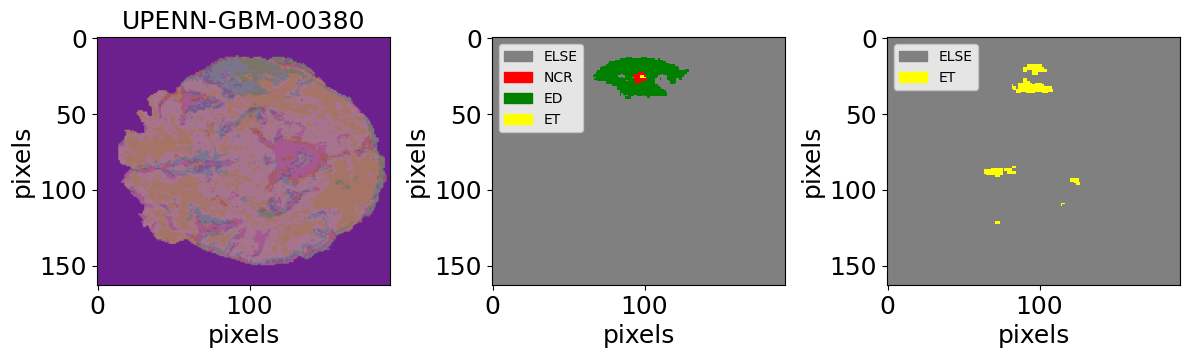

In [ ]:
# compare segmentation
input_segmentation = mf_utils.mask_to_segmentation(mask_labels=mask_true_3d[:, slice_idx, :, :], class_labels=true_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=mask_pred_3d[:, slice_idx, :, :], class_labels=pred_class_labels)
print("input segmentation shape:", input_segmentation.shape)
print("pred segmentation shape:", pred_segmentation.shape)

# cut the 3d image using the slice
mf_utils.plot_segmentation_comparison(
            input_pixel_values=image_3d[slice_idx, :, :, :],
            input_segmentation=input_segmentation,
            pred_segmentation=pred_segmentation,
            title=low_dice_img, loc="upper left")

#### 4.2.7 Make prediction ensembles

##### make and save model predictions (need to load corresponding models first)

In [281]:
### make and save predictions (need to run multiple times)
# define names
# pred_orientation = '_depth_2x'
# pred_orientation = '_cross_side_2x'
pred_orientation = '_cross_front_2x'

folder = '/predictions_new'

# ## loop subjects and make predictions
# for subj_id in val_subjs:
#     prediction_val_cur = mf_val_inference_upscaled.predict_patient_mask(subj_id)
#     # image_3d = prediction_val_cur[0]
#     # mask_true_3d = prediction_val_cur[1]
#     mask_pred_3d = prediction_val_cur[2]
#     # all_true_labels = prediction_val_cur[3]
#     # all_pred_labels = prediction_val_cur[4]

#     # save predictions
#     file_name = subj_id + pred_orientation
#     source_path = data_handler.create_temp_file(file_name)
#     torch.save(mask_pred_3d, source_path)
#     data_handler.save_from_source_path (file_name, source_path, train_dir_prefix+folder)

## loop subjects and make predictions
for subj_id in test_subjs:
    prediction_test_cur = mf_test_inference_upscaled.predict_patient_mask(subj_id)
    mask_pred_3d = prediction_test_cur[2]

    # save predictions
    file_name = subj_id + pred_orientation
    source_path = data_handler.create_temp_file(file_name)
    torch.save(mask_pred_3d, source_path)
    data_handler.save_from_source_path (file_name, source_path, train_dir_prefix+folder)

Performing inference on UPENN-GBM-00002
batch size 10
Performing inference on UPENN-GBM-00014
batch size 10
Performing inference on UPENN-GBM-00026
batch size 10
Performing inference on UPENN-GBM-00059
batch size 10
Performing inference on UPENN-GBM-00062
batch size 10
Performing inference on UPENN-GBM-00106
batch size 10
Performing inference on UPENN-GBM-00113
batch size 10
Performing inference on UPENN-GBM-00115
batch size 10
Performing inference on UPENN-GBM-00136
batch size 10
Performing inference on UPENN-GBM-00146
batch size 10
Performing inference on UPENN-GBM-00147
batch size 10
Performing inference on UPENN-GBM-00149
batch size 10
Performing inference on UPENN-GBM-00156
batch size 10
Performing inference on UPENN-GBM-00173
batch size 10
Performing inference on UPENN-GBM-00193
batch size 10
Performing inference on UPENN-GBM-00196
batch size 10
Performing inference on UPENN-GBM-00215
batch size 10
Performing inference on UPENN-GBM-00227
batch size 10
Performing inference on UPEN

In [282]:
mask_pred_3d.shape

(4, 193, 163, 146)

In [203]:
# obtain ground truth mask and save it
# currently, this needs to be compuated on the depth orientation to be consistent with data loading below

folder = '/predictions_new'

org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
])

mf_eval = MaskFormerEvaluation(use_brats_region=False)

# mf_test_inference_org = MaskFormerInference(data_handler=data_handler,
#                                             data_identifier=MY_MRI_TYPE_VAL,
#                                             model=model,
#                                             processor=processor,
#                                             upscaled_transform=org_transform,
#                                             scale_to_orig_size=False)
# for subj_id in val_subjs:
#     prediction_val_cur = mf_val_inference_org.predict_patient_mask(subj_id)
#     mask_true_3d = prediction_val_cur[1]

#     # save predictions
#     file_name = subj_id + "_ground_truth"
#     source_path = data_handler.create_temp_file(file_name)
#     torch.save(mask_true_3d, source_path)
#     data_handler.save_from_source_path (file_name, source_path, train_dir_prefix+folder)


mf_test_inference_org = MaskFormerInference(data_handler=data_handler,
                                            data_identifier=MY_MRI_TYPE_TEST,
                                            model=model,
                                            processor=processor,
                                            upscaled_transform=org_transform,
                                            scale_to_orig_size=False)
for subj_id in test_subjs:
    prediction_test_cur = mf_test_inference_org.predict_patient_mask(subj_id)
    mask_true_3d = prediction_test_cur[1]

    # save predictions
    file_name = subj_id + "_ground_truth"
    source_path = data_handler.create_temp_file(file_name)
    torch.save(mask_true_3d, source_path)
    data_handler.save_from_source_path (file_name, source_path, train_dir_prefix+folder)

Performing inference on UPENN-GBM-00002
batch size 10
Performing inference on UPENN-GBM-00014
batch size 10
Performing inference on UPENN-GBM-00026
batch size 10
Performing inference on UPENN-GBM-00059
batch size 10
Performing inference on UPENN-GBM-00062
batch size 10
Performing inference on UPENN-GBM-00106
batch size 10
Performing inference on UPENN-GBM-00113
batch size 10
Performing inference on UPENN-GBM-00115
batch size 10
Performing inference on UPENN-GBM-00136
batch size 10
Performing inference on UPENN-GBM-00146
batch size 10
Performing inference on UPENN-GBM-00147
batch size 10
Performing inference on UPENN-GBM-00149
batch size 10
Performing inference on UPENN-GBM-00156
batch size 10
Performing inference on UPENN-GBM-00173
batch size 10
Performing inference on UPENN-GBM-00193
batch size 10
Performing inference on UPENN-GBM-00196
batch size 10
Performing inference on UPENN-GBM-00215
batch size 10
Performing inference on UPENN-GBM-00227
batch size 10
Performing inference on UPEN

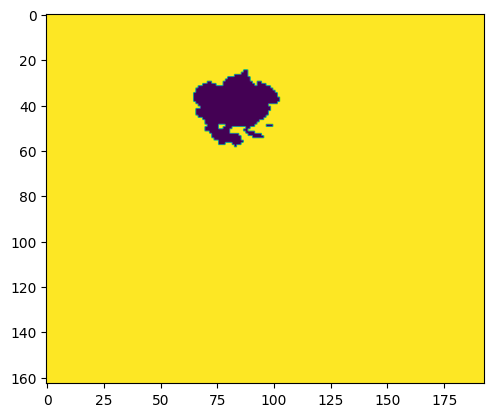

In [245]:
plt.imshow(mask_true_3d[0,73,:,:])

In [205]:
mask_true_3d.shape

(4, 146, 163, 193)

In [247]:
mask_pred_3d.shape

(4, 163, 193, 146)

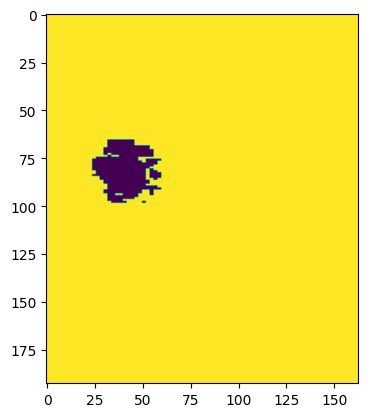

In [284]:
plt.imshow(mask_pred_3d[0,:,:,73])

##### load and integrate model predictions

In [300]:
# load true mask and all predictions
folder = '/predictions_new'

# select validation or test subjects
# subj_list = list(val_subjs)
subj_list = list(test_subjs)

# mask_depth_512 = '_depth_512'
# mask_depth_2x = '_depth_2x'
# mask_cross_side_2x = '_cross_side_2x'
mask_true = '_ground_truth'
mask_depth_2x = '_depth_2x'
mask_cross_side_2x = '_cross_side_2x'
mask_cross_front_2x = '_cross_front_2x'

d1 = 4 # number of labels
d2 = 146 # n depth
d3 = 163 # n side
d4 = 193 # n front

# orientation_list = [mask_depth_512, mask_depth_2x, mask_cross_side_2x]
orientation_list = [mask_depth_2x, mask_cross_side_2x, mask_cross_front_2x]

masks_3d_true = np.zeros((len(subj_list), d1, d2, d3, d4), dtype='uint8')

masks_3d_pred = np.zeros((len(subj_list), len(orientation_list), d1, d2, d3, d4), dtype='uint8')

for isubj, subj in enumerate(subj_list):
    print('loading predcited and true masks for subject', subj)
    file_name = subj + mask_true
    stream_data = data_handler.load_from_stream(file_name, train_dir_prefix+folder)
    masks_3d_true[isubj,:,:,:,:] = torch.load(stream_data)/255.0

    for idx in range(len(orientation_list)):
        file_name = subj + orientation_list[idx]
        stream_data = data_handler.load_from_stream(file_name, train_dir_prefix+folder)
        temp_data = torch.load(stream_data)
        if orientation_list[idx] == '_cross_side_2x':
            masks_3d_pred[isubj,idx,:,:,:,:] = temp_data.transpose(0,3,1,2)/255.0
        elif orientation_list[idx] == '_cross_front_2x':
            masks_3d_pred[isubj,idx,:,:,:,:] = temp_data.transpose(0,3,2,1)/255.0
        else:
            masks_3d_pred[isubj,idx,:,:,:,:] = temp_data/255.0


loading predcited and true masks for subject UPENN-GBM-00002
loading predcited and true masks for subject UPENN-GBM-00014
loading predcited and true masks for subject UPENN-GBM-00026
loading predcited and true masks for subject UPENN-GBM-00059
loading predcited and true masks for subject UPENN-GBM-00062
loading predcited and true masks for subject UPENN-GBM-00106
loading predcited and true masks for subject UPENN-GBM-00113
loading predcited and true masks for subject UPENN-GBM-00115
loading predcited and true masks for subject UPENN-GBM-00136
loading predcited and true masks for subject UPENN-GBM-00146
loading predcited and true masks for subject UPENN-GBM-00147
loading predcited and true masks for subject UPENN-GBM-00149
loading predcited and true masks for subject UPENN-GBM-00156
loading predcited and true masks for subject UPENN-GBM-00173
loading predcited and true masks for subject UPENN-GBM-00193
loading predcited and true masks for subject UPENN-GBM-00196
loading predcited and tr

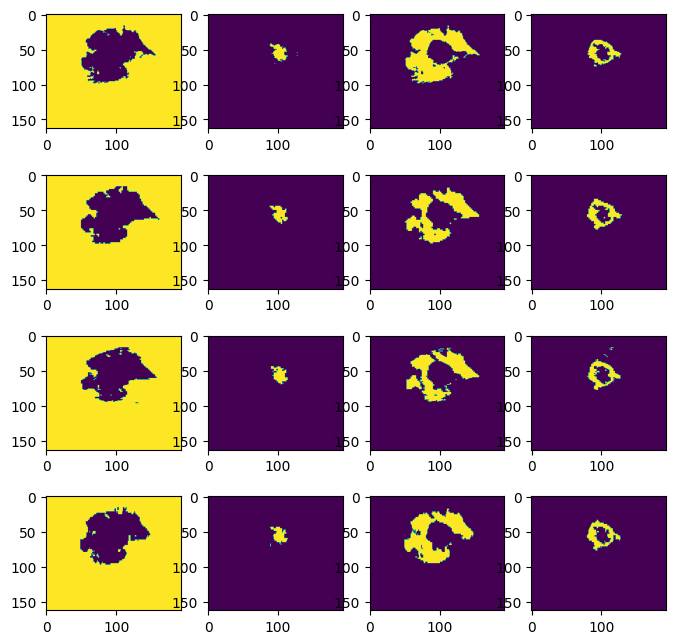

In [304]:
### QC plots

isubj_test = 0
idepth = 70
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
axes[0,0].imshow(masks_3d_true[isubj_test,0,idepth,:,:])
axes[1,0].imshow(masks_3d_pred[isubj_test,0,0,idepth,:,:])
axes[2,0].imshow(masks_3d_pred[isubj_test,1,0,idepth,:,:])
axes[3,0].imshow(masks_3d_pred[isubj_test,2,0,idepth,:,:])
axes[0,1].imshow(masks_3d_true[isubj_test,1,idepth,:,:])
axes[1,1].imshow(masks_3d_pred[isubj_test,0,1,idepth,:,:])
axes[2,1].imshow(masks_3d_pred[isubj_test,1,1,idepth,:,:])
axes[3,1].imshow(masks_3d_pred[isubj_test,2,1,idepth,:,:])
axes[0,2].imshow(masks_3d_true[isubj_test,2,idepth,:,:])
axes[1,2].imshow(masks_3d_pred[isubj_test,0,2,idepth,:,:])
axes[2,2].imshow(masks_3d_pred[isubj_test,1,2,idepth,:,:])
axes[3,2].imshow(masks_3d_pred[isubj_test,2,2,idepth,:,:])
axes[0,3].imshow(masks_3d_true[isubj_test,3,idepth,:,:])
axes[1,3].imshow(masks_3d_pred[isubj_test,0,3,idepth,:,:])
axes[2,3].imshow(masks_3d_pred[isubj_test,1,3,idepth,:,:])
axes[3,3].imshow(masks_3d_pred[isubj_test,2,3,idepth,:,:])

In [305]:
# obtain a new mask by aggregation of predicted masks

# compuate average
masks_3d_agg = np.mean(masks_3d_pred, axis=1)

# Define the two values you want to round to
rounded_value_1 = 0
rounded_value_2 = 1

# Set the condition for rounding
condition = masks_3d_agg >= (rounded_value_1+rounded_value_2)/2
# condition = masks_3d_agg >= 0.1

# Use numpy.where() to round values to the specified values based on the condition
masks_3d_agg = np.where(condition, rounded_value_2, rounded_value_1)
masks_3d_agg = masks_3d_agg.astype('uint8')

In [306]:
subj_list

['UPENN-GBM-00002',
 'UPENN-GBM-00014',
 'UPENN-GBM-00026',
 'UPENN-GBM-00059',
 'UPENN-GBM-00062',
 'UPENN-GBM-00106',
 'UPENN-GBM-00113',
 'UPENN-GBM-00115',
 'UPENN-GBM-00136',
 'UPENN-GBM-00146',
 'UPENN-GBM-00147',
 'UPENN-GBM-00149',
 'UPENN-GBM-00156',
 'UPENN-GBM-00173',
 'UPENN-GBM-00193',
 'UPENN-GBM-00196',
 'UPENN-GBM-00215',
 'UPENN-GBM-00227',
 'UPENN-GBM-00238',
 'UPENN-GBM-00256',
 'UPENN-GBM-00266',
 'UPENN-GBM-00270',
 'UPENN-GBM-00277',
 'UPENN-GBM-00330',
 'UPENN-GBM-00351',
 'UPENN-GBM-00368',
 'UPENN-GBM-00373',
 'UPENN-GBM-00384',
 'UPENN-GBM-00418']

Text(0.5, 1.0, 'Dice Score:0.8651')

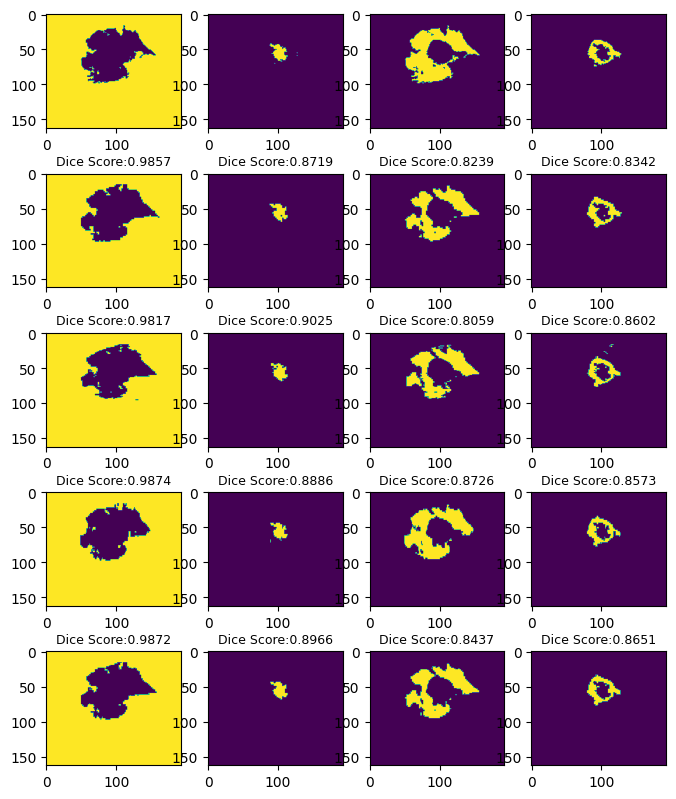

In [307]:
# isubj_test = 3
# idepth = 70
isubj_test = 0
idepth = 70
my_fontsize = 9

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 10))

axes[0,0].imshow(masks_3d_true[isubj_test,0,idepth,:,:])
axes[0,1].imshow(masks_3d_true[isubj_test,1,idepth,:,:])
axes[0,2].imshow(masks_3d_true[isubj_test,2,idepth,:,:])
axes[0,3].imshow(masks_3d_true[isubj_test,3,idepth,:,:])

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,0,0,idepth,:,:], masks_3d_true[isubj_test,0,idepth,:,:])
axes[1,0].imshow(masks_3d_pred[isubj_test,0,0,idepth,:,:])
axes[1,0].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,0,1,idepth,:,:], masks_3d_true[isubj_test,1,idepth,:,:])
axes[1,1].imshow(masks_3d_pred[isubj_test,0,1,idepth,:,:])
axes[1,1].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,0,2,idepth,:,:], masks_3d_true[isubj_test,2,idepth,:,:])
axes[1,2].imshow(masks_3d_pred[isubj_test,0,2,idepth,:,:])
axes[1,2].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,0,3,idepth,:,:], masks_3d_true[isubj_test,3,idepth,:,:])
axes[1,3].imshow(masks_3d_pred[isubj_test,0,3,idepth,:,:])
axes[1,3].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,1,0,idepth,:,:], masks_3d_true[isubj_test,0,idepth,:,:])
axes[2,0].imshow(masks_3d_pred[isubj_test,1,0,idepth,:,:])
axes[2,0].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,1,1,idepth,:,:], masks_3d_true[isubj_test,1,idepth,:,:])
axes[2,1].imshow(masks_3d_pred[isubj_test,1,1,idepth,:,:])
axes[2,1].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,1,2,idepth,:,:], masks_3d_true[isubj_test,2,idepth,:,:])
axes[2,2].imshow(masks_3d_pred[isubj_test,1,2,idepth,:,:])
axes[2,2].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,1,3,idepth,:,:], masks_3d_true[isubj_test,3,idepth,:,:])
axes[2,3].imshow(masks_3d_pred[isubj_test,1,3,idepth,:,:])
axes[2,3].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,2,0,idepth,:,:], masks_3d_true[isubj_test,0,idepth,:,:])
axes[3,0].imshow(masks_3d_pred[isubj_test,2,0,idepth,:,:])
axes[3,0].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,2,1,idepth,:,:], masks_3d_true[isubj_test,1,idepth,:,:])
axes[3,1].imshow(masks_3d_pred[isubj_test,2,1,idepth,:,:])
axes[3,1].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,2,2,idepth,:,:], masks_3d_true[isubj_test,2,idepth,:,:])
axes[3,2].imshow(masks_3d_pred[isubj_test,2,2,idepth,:,:])
axes[3,2].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,2,3,idepth,:,:], masks_3d_true[isubj_test,3,idepth,:,:])
axes[3,3].imshow(masks_3d_pred[isubj_test,2,3,idepth,:,:])
axes[3,3].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,0,idepth,:,:], masks_3d_true[isubj_test,0,idepth,:,:])
axes[4,0].imshow(masks_3d_agg[isubj_test,0,idepth,:,:])
axes[4,0].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,1,idepth,:,:], masks_3d_true[isubj_test,1,idepth,:,:])
axes[4,1].imshow(masks_3d_agg[isubj_test,1,idepth,:,:])
axes[4,1].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,2,idepth,:,:], masks_3d_true[isubj_test,2,idepth,:,:])
axes[4,2].imshow(masks_3d_agg[isubj_test,2,idepth,:,:])
axes[4,2].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)

dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,3,idepth,:,:], masks_3d_true[isubj_test,3,idepth,:,:])
axes[4,3].imshow(masks_3d_agg[isubj_test,3,idepth,:,:])
axes[4,3].set_title('Dice Score:'+str(round(dice_score,4)), fontsize=my_fontsize)


In [308]:
# measure similarity between predictions and ground truth

dice_score_results = np.zeros((4, len(subj_list), 4))

for isubj_test in range(len(subj_list)):
    print('Subject',subj_list[isubj_test])
    for icat in range(4):
        # print('Subject',subj_list[isubj_test],'class',id2label[icat])

        dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,0,icat,:,:,:], masks_3d_true[isubj_test,icat,:,:,:])
        dice_score_results[0, isubj_test,icat] = dice_score
        # print('Dice Score model 1 '+str(round(dice_score,4)))

        dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,1,icat,:,:,:], masks_3d_true[isubj_test,icat,:,:,:])
        dice_score_results[1, isubj_test,icat] = dice_score
        # print('Dice Score model 2 '+str(round(dice_score,4)))

        dice_score = metrics.calc_dice_score(masks_3d_pred[isubj_test,2,icat,:,:,:], masks_3d_true[isubj_test,icat,:,:,:])
        dice_score_results[2, isubj_test,icat] = dice_score
        # print('Dice Score model 3 '+str(round(dice_score,4)))

        dice_score = metrics.calc_dice_score(masks_3d_agg[isubj_test,icat,:,:,:], masks_3d_true[isubj_test,icat,:,:,:])
        dice_score_results[3, isubj_test,icat] = dice_score
        # print('Dice Score model all '+str(round(dice_score,4)))



Subject UPENN-GBM-00002
Subject UPENN-GBM-00014
Subject UPENN-GBM-00026
Subject UPENN-GBM-00059
Subject UPENN-GBM-00062
Subject UPENN-GBM-00106
Subject UPENN-GBM-00113
Subject UPENN-GBM-00115
Subject UPENN-GBM-00136
Subject UPENN-GBM-00146
Subject UPENN-GBM-00147
Subject UPENN-GBM-00149
Subject UPENN-GBM-00156
Subject UPENN-GBM-00173
Subject UPENN-GBM-00193
Subject UPENN-GBM-00196
Subject UPENN-GBM-00215
Subject UPENN-GBM-00227
Subject UPENN-GBM-00238
Subject UPENN-GBM-00256
Subject UPENN-GBM-00266
Subject UPENN-GBM-00270
Subject UPENN-GBM-00277
Subject UPENN-GBM-00330
Subject UPENN-GBM-00351
Subject UPENN-GBM-00368
Subject UPENN-GBM-00373
Subject UPENN-GBM-00384
Subject UPENN-GBM-00418


In [ ]:
# import joblib
# metrics_temp_file = data_handler.load_to_temp_file(file_name="upscaled_metrics_val_depth_epoch50.joblib",
#                                                    train_dir_prefix=metrics_dir_prefix)

# metrics_summary = joblib.load(metrics_temp_file)

# # metrics_summary['scores'].keys()
# # type(metrics_summary['scores']['dice_score'])
# # metrics_summary['scores']['dice_score'].shape

###### box plots

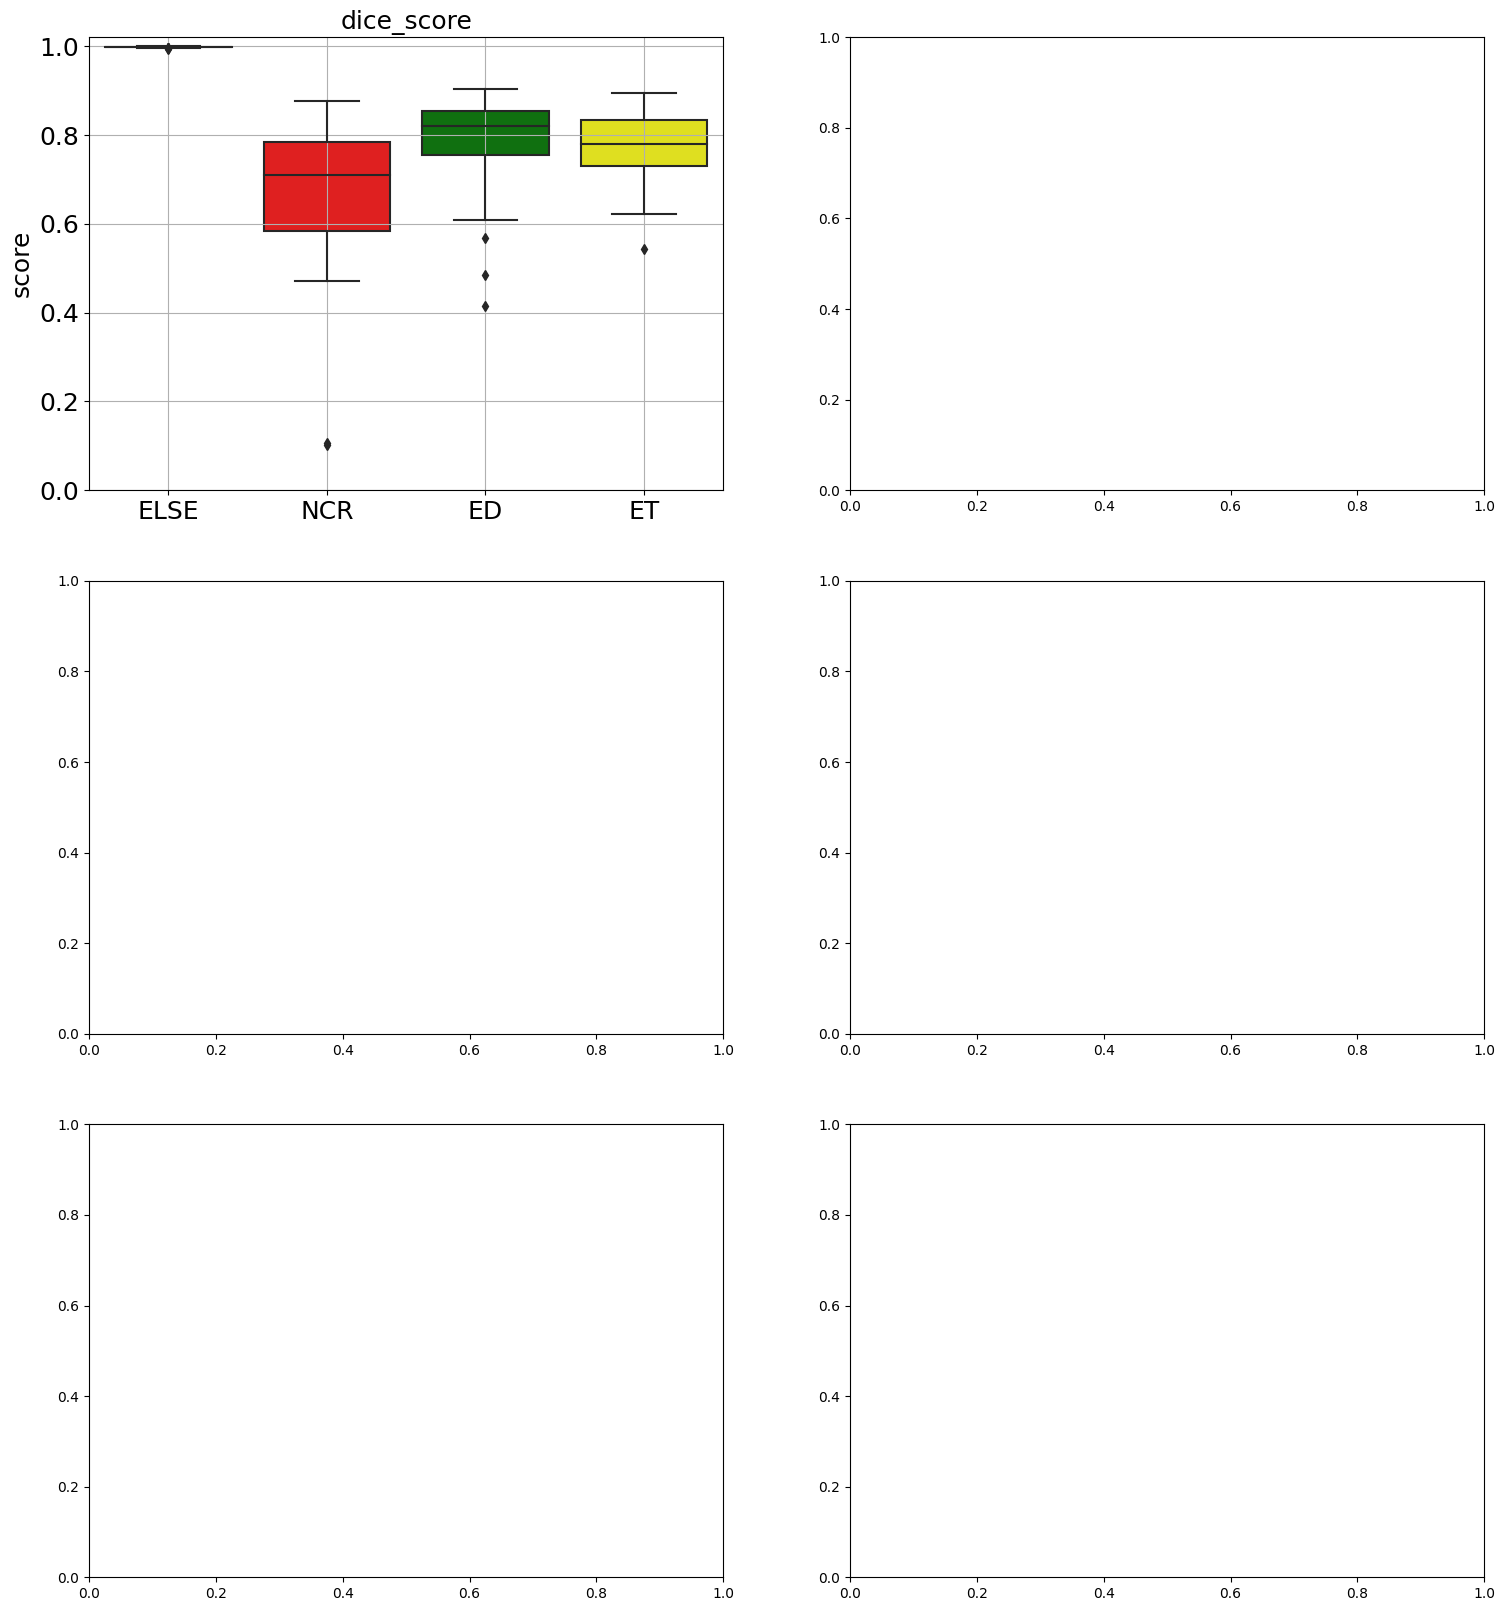

0.7629


In [309]:
metrics_dict = {}
metrics_dict['dice_score'] = dice_score_results[0,:]
mf_eval.draw_box_plots(metrics_dict, set_ylim=True)
print(round(dice_score_results[0,:,3].mean(),4))

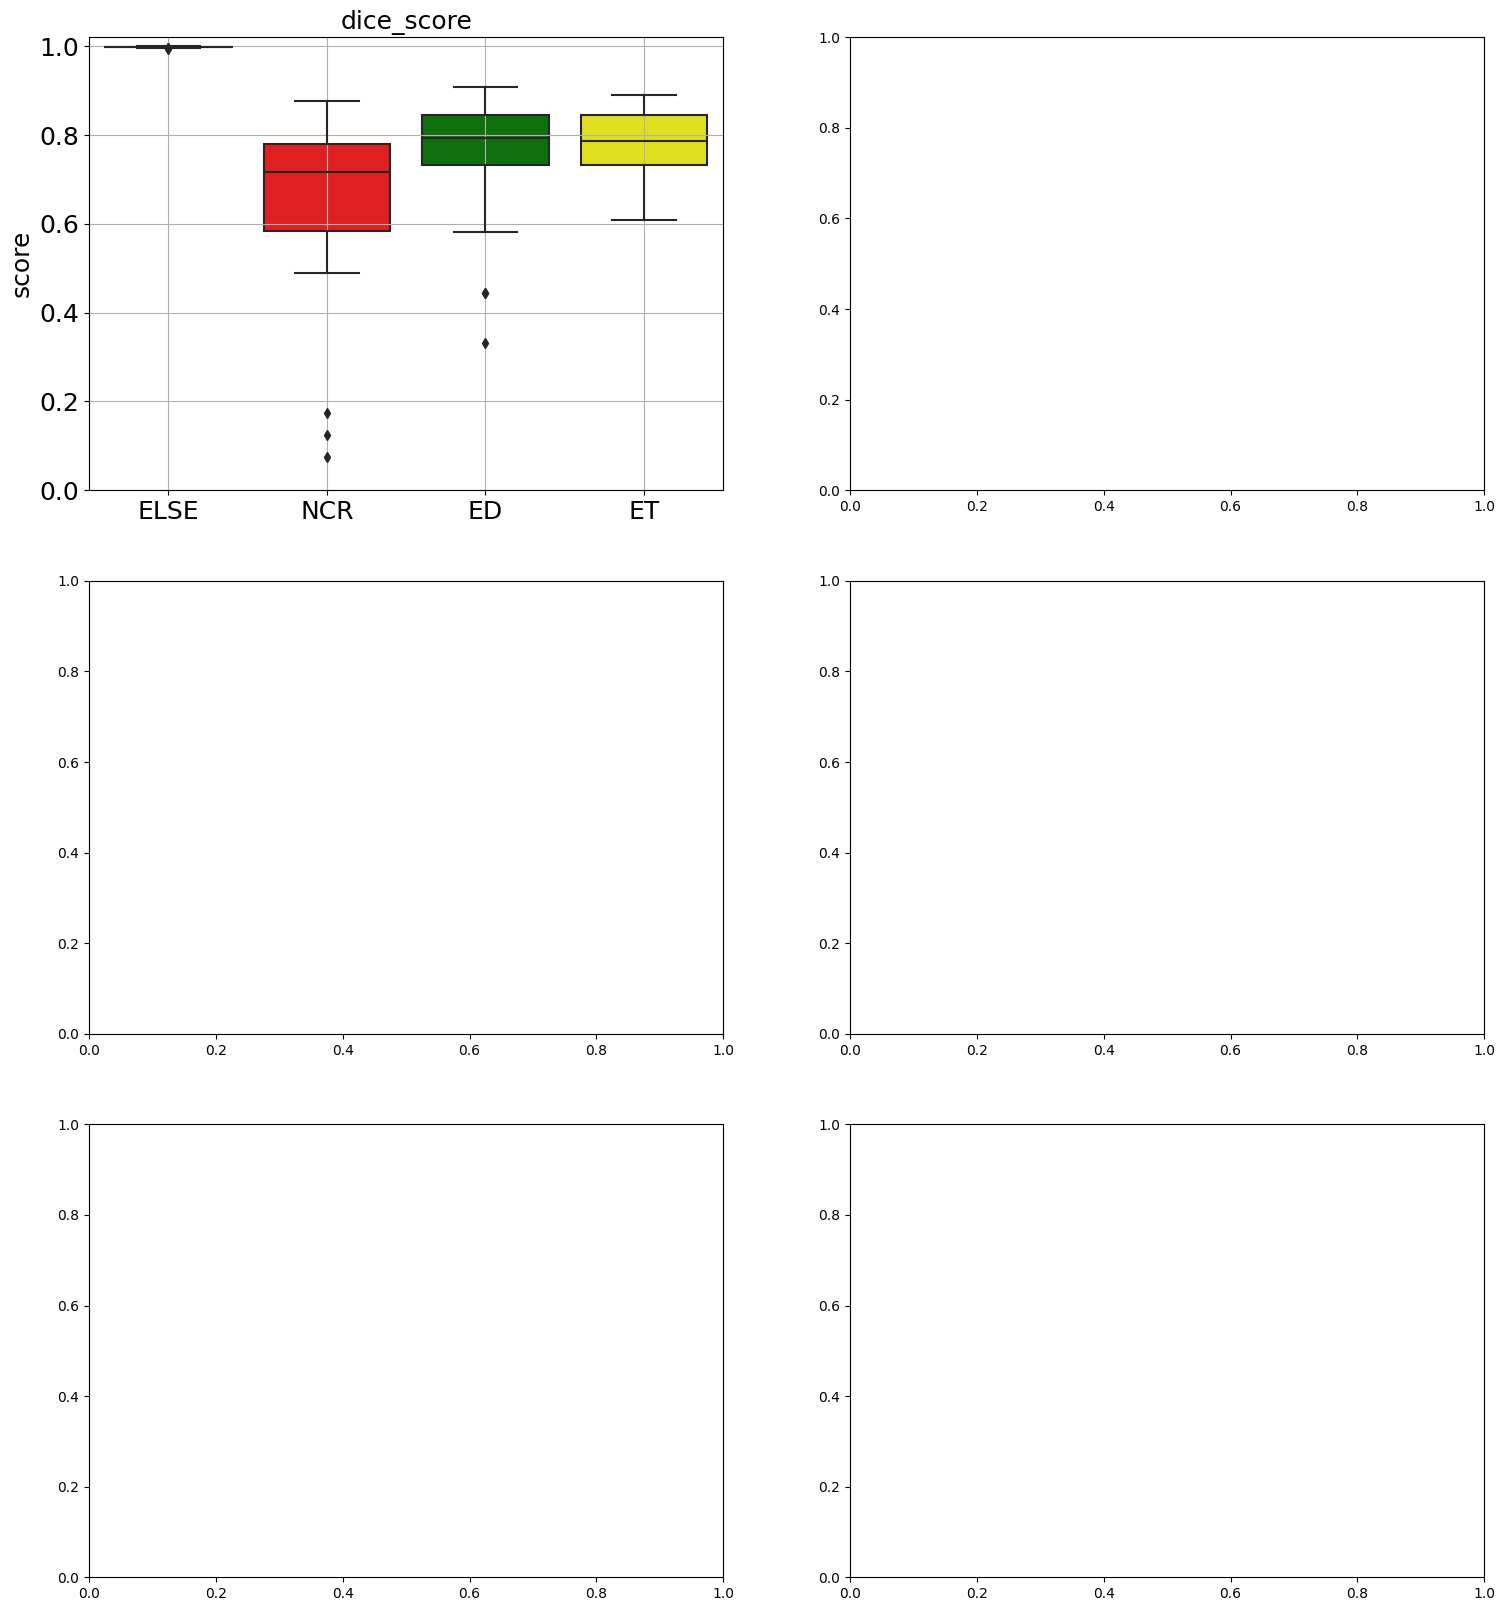

0.7794


In [310]:
metrics_dict = {}
metrics_dict['dice_score'] = dice_score_results[1,:]
mf_eval.draw_box_plots(metrics_dict, set_ylim=True)
print(round(dice_score_results[1,:,3].mean(),4))

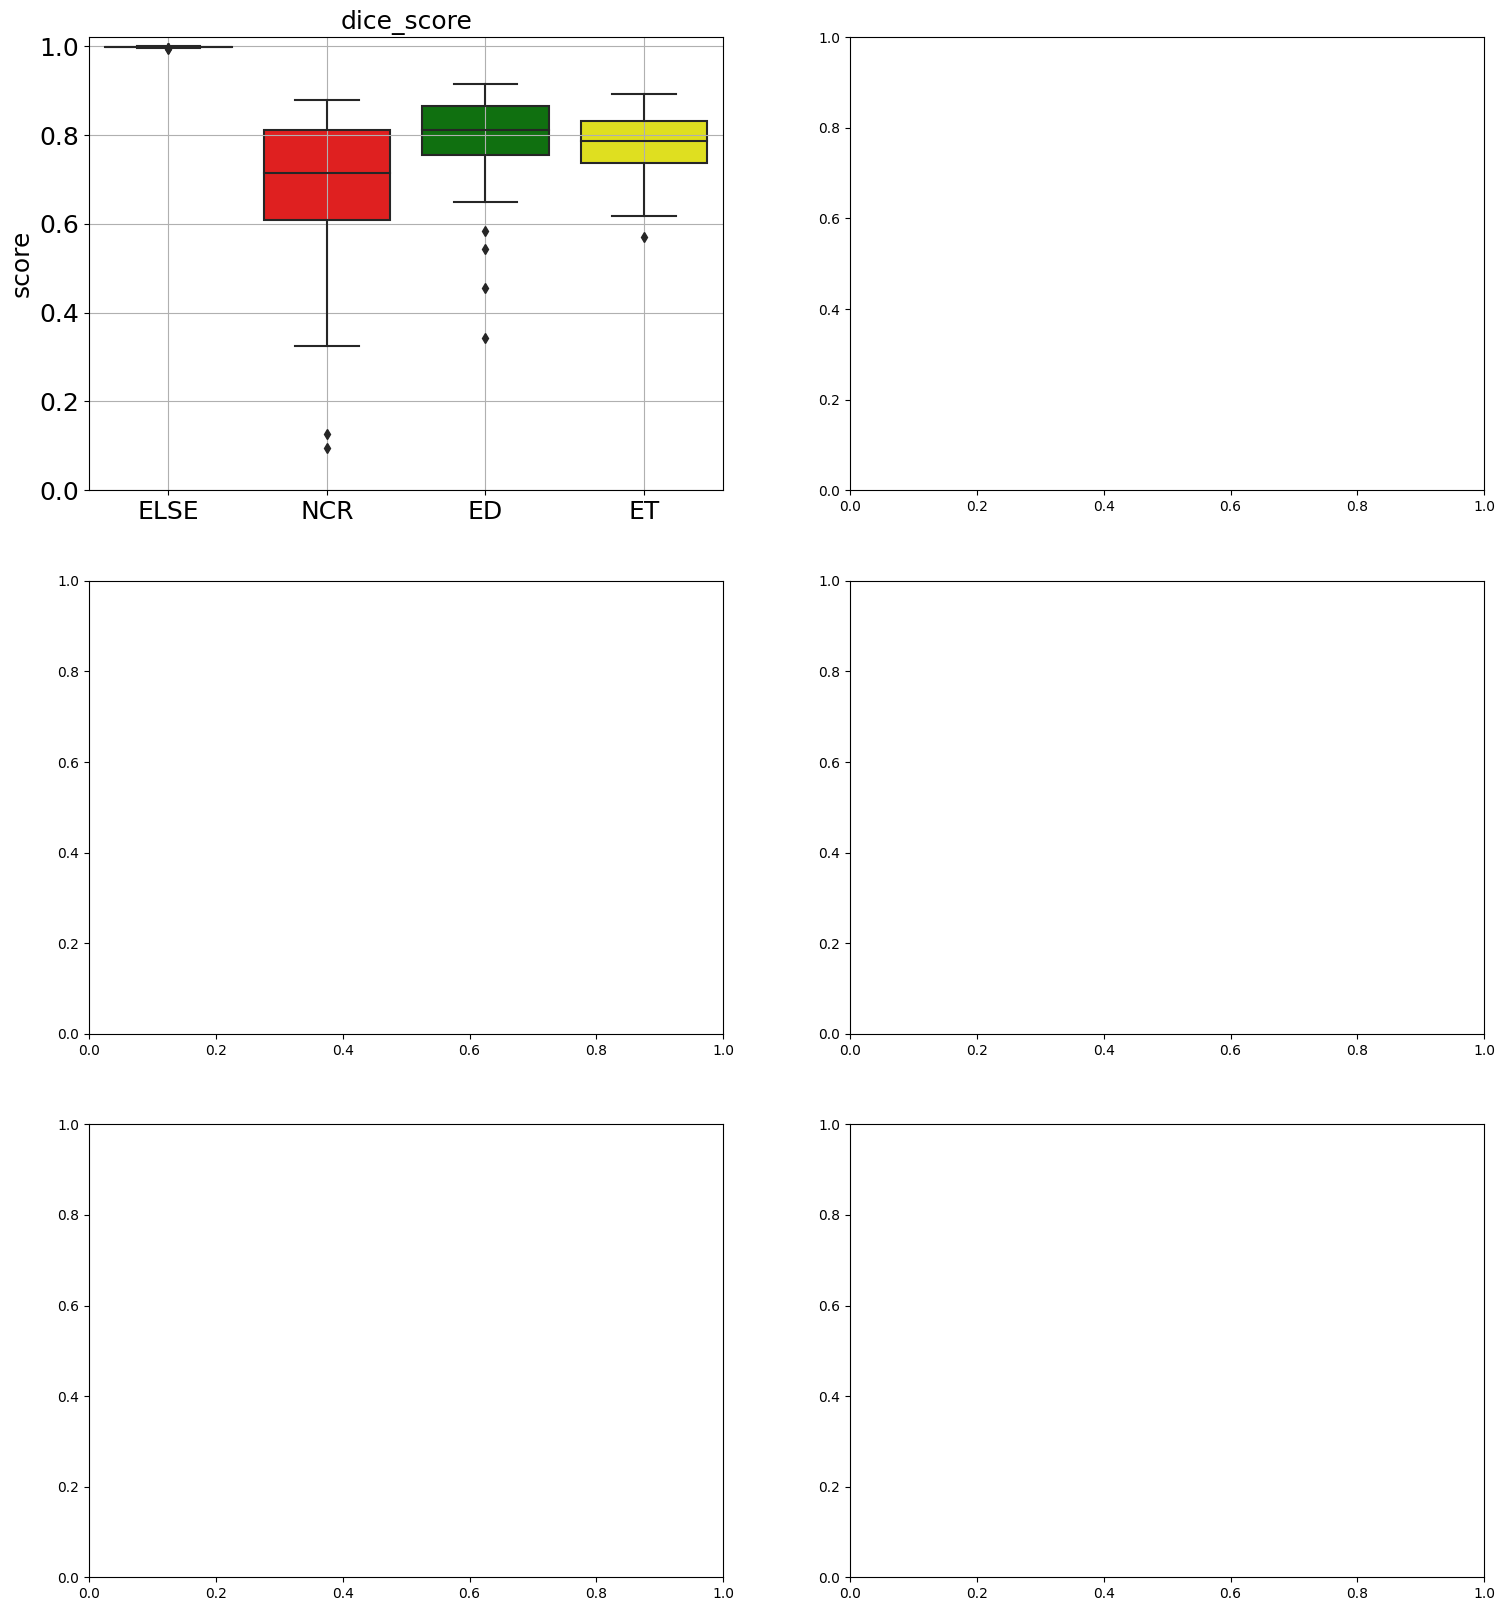

0.7704


In [311]:
metrics_dict = {}
metrics_dict['dice_score'] = dice_score_results[2,:]
mf_eval.draw_box_plots(metrics_dict, set_ylim=True)
print(round(dice_score_results[2,:,3].mean(),4))

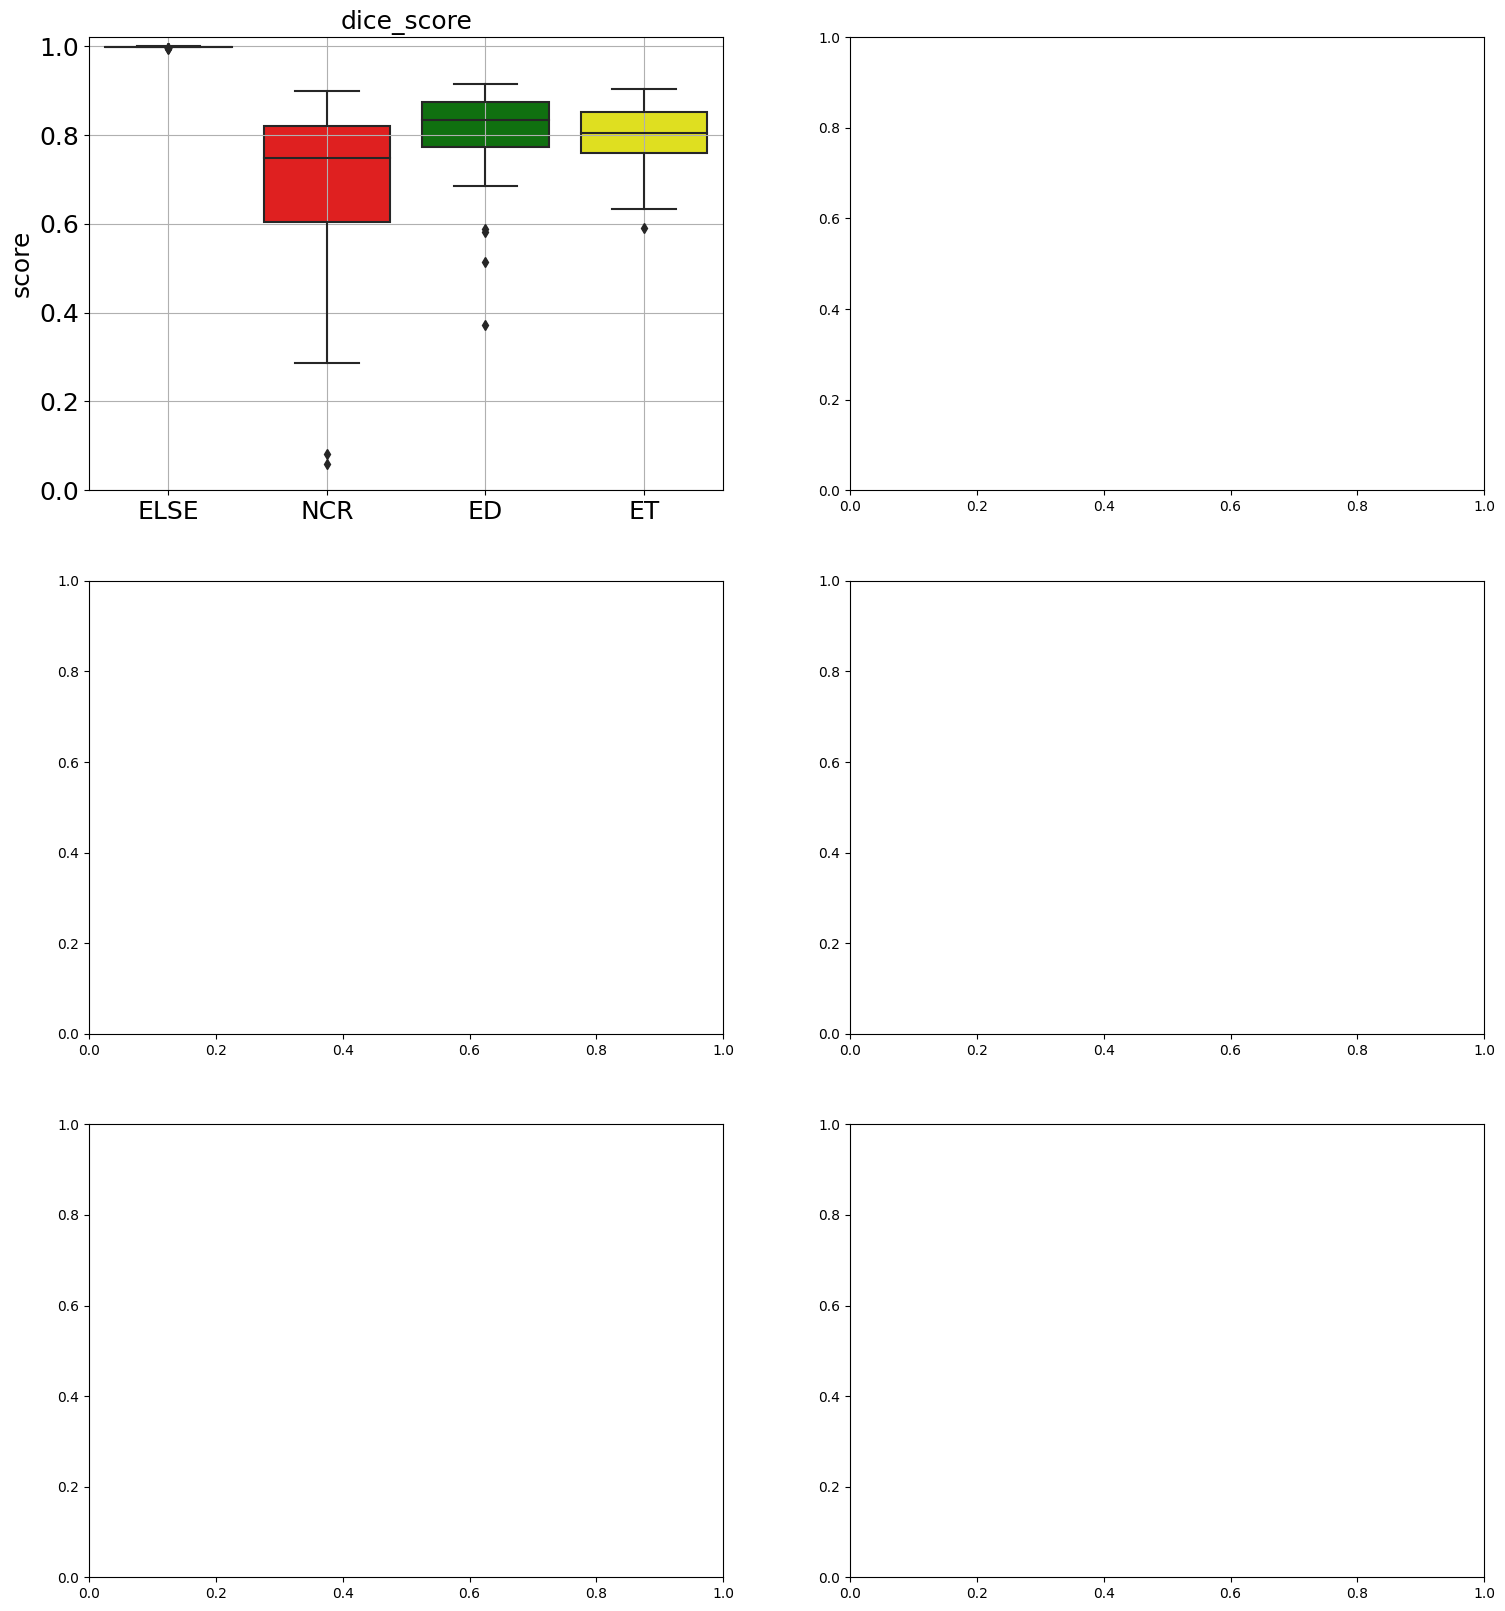

0.7881


In [312]:
metrics_dict = {}
metrics_dict['dice_score'] = dice_score_results[3,:]
mf_eval.draw_box_plots(metrics_dict, set_ylim=True)
print(round(dice_score_results[3,:,3].mean(),4))

In [313]:
dice_score_results[:,:,:].mean(axis=1)

array([[0.9978158967574179, 0.6575444020947242, 0.77676008221187  ,
        0.7629384091468213],
       [0.9978784662822199, 0.6535250492869622, 0.7564780955389344,
        0.7793735358717107],
       [0.9978890382077307, 0.6699622318609741, 0.7726487578219384,
        0.7703946116579925],
       [0.9981152887606413, 0.6793334183529725, 0.7906960914094864,
        0.7881240925032992]])

###### more

#### 4.2.4 Obtain Training datalist

In [ ]:
# Obtain full train list dataset
train_subjs = mf_utils.get_all_subj_ids(data_handler=data_handler, mri_type=MriType.TRAIN_2D_DEPTH)
print("total training data", len(val_subjs))
print("first 10 training subjects")
print(train_subjs[:10])

#### 4.2.5 Calculate Metrics for Training Data

Testing 2 samples only

In [ ]:
print("train metrics_file_name: ", train_metrics_file_name)
train_metrics_dict, train_error_files, train_success_files = mf_eval.predict_and_eval(subj_names=train_subjs,
                                                                        data_handler=data_handler,
                                                                        mf_inference=mf_train_inference,
                                                                        metrics_dir_prefix=metrics_dir_prefix,
                                                                        metrics_file_name=train_metrics_file_name,
                                                                        recalculate=RECALCULATE_TRAIN_METRICS)

#### 4.2.6 Evaluate Training Data

##### Summary statistics

In [ ]:
mf_eval.display_statistics(train_metrics_dict)

##### Box plots

In [ ]:
mf_eval.draw_box_plots(train_metrics_dict)

##### Histograms

In [ ]:
mf_eval.build_histogram(train_metrics_dict)

##### Worst Dice Score

In [ ]:
low_dice_score_train = mf_eval.get_low_dice_score_images(train_success_files, train_metrics_dict, top_n=3)
low_dice_score_train

##### Worst HD95

In [ ]:
high_hd95_train = mf_eval.get_high_hd95_images(train_success_files, train_metrics_dict, top_n=3)
high_hd95_train